In [2]:
import re
import praw
import gensim
import numpy as np

import pandas as pd
import time
from collections import Counter
import matplotlib.pyplot as plt


reddit = praw.Reddit(client_id="9UA_D1J3HDVtf2bag9EHgQ",     
                               client_secret="tlE2ifQhrua_cKqxHtKjAxmpjk7EYQ",     
                               user_agent="socialscrape") 

In [3]:
def find_top_subreddits(keyword, sort_orders=["relevance", "new", "hot", "top", "comments"], limit=200):

    subreddit_list = []
    
    for sort_order in sort_orders:
        print(f"Searching for keyword '{keyword}' with sort order '{sort_order}'")
        for submission in reddit.subreddit("all").search(keyword, sort=sort_order, limit=limit):
            subreddit_list.append(submission.subreddit.display_name)
        time.sleep(1) 
    
    subreddit_counts = Counter(subreddit_list)
    top_subreddits = pd.DataFrame(subreddit_counts.items(), columns=["Subreddit", "Post Count"])
    top_subreddits = top_subreddits.sort_values(by="Post Count", ascending=False).head(20)
    
    return top_subreddits
def scrape_posts(subreddit, keyword, sort_order, limit=None, include_comments=False, max_comments=10):

    posts = []
    
    for submission in reddit.subreddit(subreddit).search(keyword, sort=sort_order, limit=limit):
        post_data = {
            "title": submission.title,
            "selftext": submission.selftext,
            "score": submission.score,
            "num_comments": submission.num_comments,
            "created_utc": submission.created_utc,
            "url": submission.url,
            "subreddit": subreddit,
            "sort_order": sort_order
        }
        
        if include_comments:
            submission.comments.replace_more(limit=0)  
            comments = [comment.body for comment in submission.comments[:max_comments]]
            post_data["comments"] = comments
        
        posts.append(post_data)
    
    return posts
def scrape_reddit_data(
    keywords,
    sort_orders=["relevance", "new", "hot", "top", "comments"],
    post_limit=None,
    include_comments=False,
    max_comments=10
):

    all_dataframes = {}
    
    for keyword in keywords:
        print(f"Processing keyword: {keyword}")
        top_subreddits = find_top_subreddits(keyword)
        print(f"Top subreddits for '{keyword}':")
        print(top_subreddits)
        all_posts = []
        for subreddit in top_subreddits["Subreddit"]:
            print(f"Scraping subreddit: {subreddit}")
            for sort_order in sort_orders:
                print(f"  Sort order: {sort_order}")
                posts = scrape_posts(
                    subreddit, 
                    keyword, 
                    sort_order, 
                    limit=post_limit, 
                    include_comments=include_comments, 
                    max_comments=max_comments
                )
                all_posts.extend(posts)
        
        keyword_df = pd.DataFrame(all_posts)
        keyword_df["created_utc"] = pd.to_datetime(keyword_df["created_utc"], unit="s")
        all_dataframes[keyword] = keyword_df
    
    return all_dataframes


In [ ]:
keywords = ["zepto", "instamart", "blinkit"]
dataframe1 = scrape_reddit_data(
    ['zepto'],
    sort_orders=["relevance", "new", "hot", "top", "comments"],
    post_limit=None,
    include_comments=True,  
    max_comments=10  
)


In [ ]:
dataframe2= scrape_reddit_data(
    ['blinkit'],
    sort_orders=["relevance", "new", "hot", "top", "comments"],
    post_limit=None,
    include_comments=True,  
    max_comments=10  
)

Processing keyword: blinkit
Searching for keyword 'blinkit' with sort order 'relevance'
Searching for keyword 'blinkit' with sort order 'new'
Searching for keyword 'blinkit' with sort order 'hot'
Searching for keyword 'blinkit' with sort order 'top'
Searching for keyword 'blinkit' with sort order 'comments'
Top subreddits for 'blinkit':
                Subreddit  Post Count
8          Hotwheelsindia         139
1                   delhi          80
15           StartUpIndia          57
4                ps5india          41
7        CreditCardsIndia          32
9             indiasocial          31
2                   india          28
12              bangalore          23
6         developersIndia          22
40                gurgaon          17
73              hyderabad          17
3          indianstartups          16
22      IndianBeautyDeals          16
21       IndianStreetBets          12
68              IndiaTech          12
18           IndianGaming          11
13        India

In [ ]:

dataframe3= scrape_reddit_data(
    ['instamart'],
    sort_orders=["relevance", "new", "hot", "top", "comments"],
    post_limit=None,
    include_comments=True,
    max_comments=10  
)

Processing keyword: instamart
Searching for keyword 'instamart' with sort order 'relevance'
Searching for keyword 'instamart' with sort order 'new'
Searching for keyword 'instamart' with sort order 'hot'
Searching for keyword 'instamart' with sort order 'top'
Searching for keyword 'instamart' with sort order 'comments'
Top subreddits for 'instamart':
             Subreddit  Post Count
7     CreditCardsIndia         190
8               swiggy          78
1                delhi          48
11        StartUpIndia          37
9            bangalore          31
12         indiasocial          28
13           hyderabad          25
4               mumbai          24
0              manipal          21
121    CricketShitpost          17
15               Kochi          16
2       indianstartups          15
113            Chennai          13
58   IndianStockMarket          13
19              nagpur          13
90    IndianStreetBets          13
3    indianbeautyhauls          12
6      developers

In [50]:
zepto,blinkit,instamart=dataframe1['zepto'].drop_duplicates(subset='title'),dataframe2['blinkit'].drop_duplicates(subset='title'),dataframe3['instamart'].drop_duplicates(subset='title')

In [51]:
tot_com=0
for i in [blinkit,instamart,zepto]:
    for ind,j in i.iterrows():
        if j['num_comments']<10:
            tot_com+=j['num_comments']
        else:
            tot_com+=10

tot_com

18356

In [52]:
zepto.to_json('zepto.json')
instamart.to_json('instamart.json')
blinkit.to_json('blinkit.json')

In [4]:
zepto=pd.read_json('zepto.json')
blinkit=pd.read_json('blinkit.json')
instamart=pd.read_json('instamart.json')


In [5]:
def filter_by_keyword(df, keyword):

    pattern = rf'\b{keyword}\b'
    keyword_filter = df['title'].str.contains(pattern, case=False, na=False) | \
                     df['selftext'].str.contains(pattern, case=False, na=False)
    return df[keyword_filter]




In [6]:
zepto = filter_by_keyword(zepto, 'zepto')
blinkit = filter_by_keyword(blinkit, 'blinkit')
instamart = filter_by_keyword(instamart, 'instamart')

In [7]:
def remove_specific_comments(df, column_name):
  def filter_comments(comments):
    filtered_comments = [comment for comment in comments 
                         if not ('contribution' in comment.lower() or 'awarded' in comment.lower() or 'discord' in comment.lower() or 'blinkit' in comment.lower() or 'instamart' in comment.lower())]
    return ','.join(filtered_comments)

  df[column_name] = df[column_name].apply(filter_comments)
  return df

In [8]:

zepto = remove_specific_comments(zepto, 'comments')
instamart = remove_specific_comments(instamart, 'comments')
blinkit = remove_specific_comments(blinkit, 'comments')

In [9]:
def split_data(df):
    validation_df = df.sample(n=10, random_state=24) 
    remaining_df = df.drop(validation_df.index)

    return validation_df, remaining_df

In [10]:

import emoji

text_emojis = [
    r":\)", r":\(", r":P", r";\)", r":D", r":O", r":p", r"<3", r":'\(", r":'\)",
    r":-?\)", r":-?\(", r":-?P", r":-?p", r";-?\)", r":-?D", r":-?O", r"<3"
]

# Compile the regex pattern for text emojis
text_emoji_pattern = re.compile('|'.join(text_emojis))

def retain_emojis(text):
    return ''.join([
        ch if ch.isalnum() or ch.isspace() or ch in emoji.EMOJI_DATA or text_emoji_pattern.match(ch)
        else '' for ch in text
    ])

def preprocess(df):
    df['selftext'] = df['selftext']
    df['posttext'] = df['title'].astype(str) + ' '+ df['selftext'].astype(str)
    df['all_text'] = df['title'].astype(str) + ' '+ df['selftext'].astype(str)+' ' + df['comments'].astype(str)
    df['selftext'] = df['selftext'].apply(lambda x: re.sub(r'http\S+', '', str(x)))
    df['selftext'] = df['selftext'].apply(retain_emojis).str.lower()
    df.replace('NaN', np.nan, inplace=True)
    df.fillna('', inplace=True)
    df['all_text'] = df['all_text'].apply(lambda x: re.sub(r'http\S+', '', str(x)))
    df['all_text'] = df['all_text'].apply(retain_emojis).str.lower()
    
    return df


In [11]:
print(len(zepto),len(blinkit),len(instamart))

514 671 414


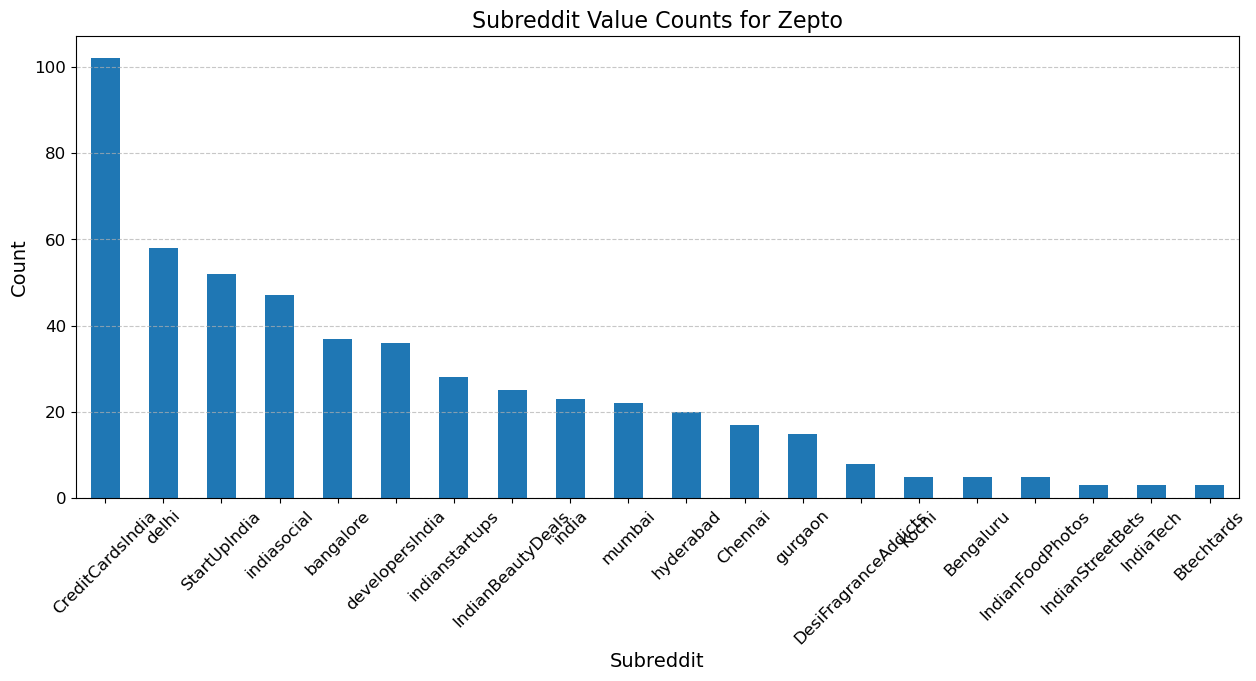

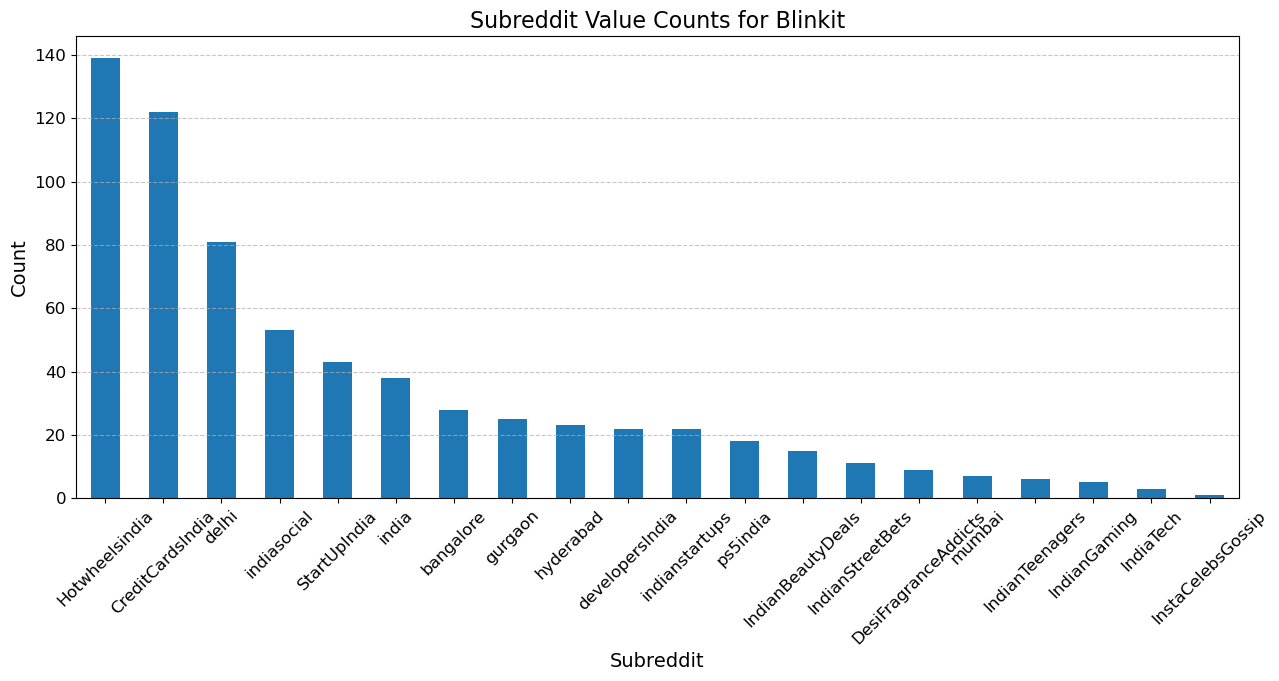

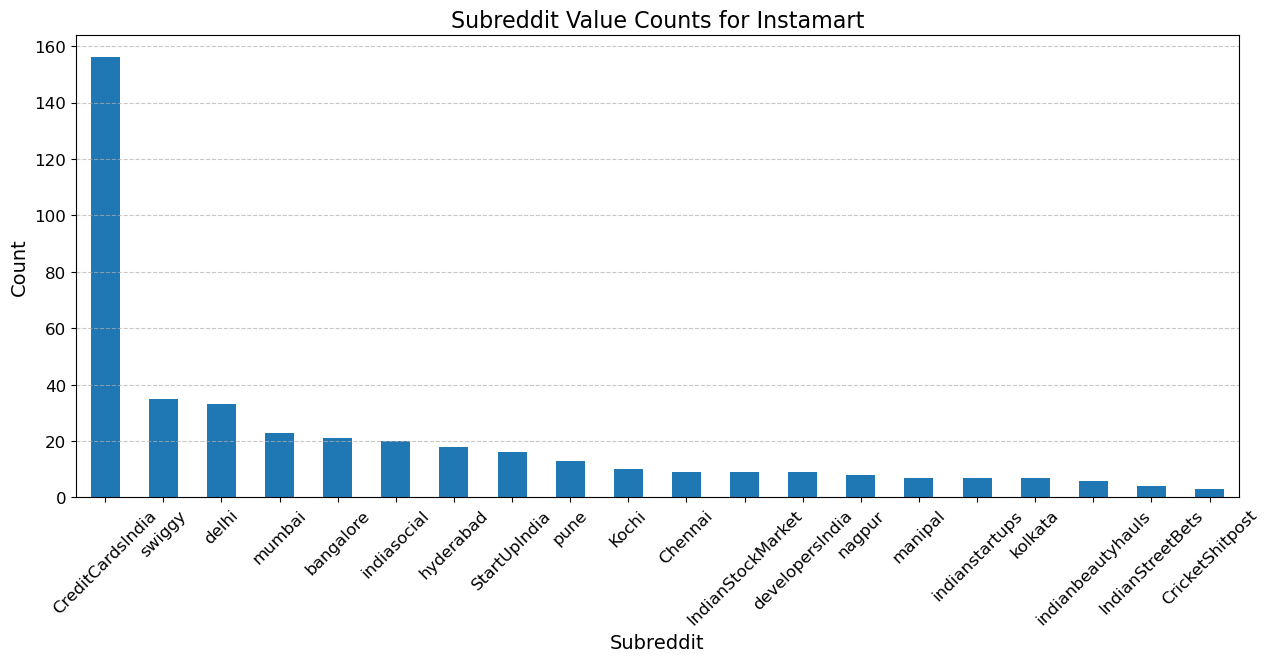

In [12]:
def plot_subreddit_counts(df, title):
    subreddit_counts = df['subreddit'].value_counts()
    plt.figure(figsize=(15, 6)) 
    subreddit_counts.plot(kind='bar')
    plt.title(title, fontsize=16)
    plt.xlabel('Subreddit', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_subreddit_counts(zepto, 'Subreddit Value Counts for Zepto')
plot_subreddit_counts(blinkit, 'Subreddit Value Counts for Blinkit')
plot_subreddit_counts(instamart, 'Subreddit Value Counts for Instamart')

In [13]:
zepto=preprocess(zepto)
blinkit=preprocess(blinkit)
instamart=preprocess(instamart)

In [14]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mansha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mansha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mansha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
zepto_val,zepto_df=split_data(zepto)
instamart_val,instamart_df=split_data(instamart)
blinkit_val,blinkit_df=split_data(blinkit)

In [30]:
zepto_df,instamart_df,blinkit_df=zepto,instamart,blinkit

In [17]:
from nltk.stem import PorterStemmer
from nltk import word_tokenize, bigrams

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
custom_stopwords = set(stopwords.words("english"))
custom_stopwords.update(["zepto", 'like','use','was','dont','make','will','hello','order','like',"blinkit", "swiiggy", "instamart","delivery",'make','spend','use','spend','one','go','also','order','pay','people','good',"about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always","am", "among", "amongst", "amoungst", "amount", "an", "and", "another","any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "because", "been", "before", "beforehand", "being", "beside", "besides", "between", "both", "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con", "could", "couldnt" "de", "did", "didn't", "do", "does", "doesn't", "don't", "done", "down",
    "due", "during", "each", "eg", "eight", "either", "eleven", "else", "elsewhere", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty","community","ka",'मधय','glti','krdi',
    "found", "four", "from", "front", "full", "further", "get", "give", "go","1","10","r",'ive',
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "https", "hundred", "ie", "if", "in", "inc", "indeed",
    "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly",
    "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might",'apps',
    "mill", "mine", "more", "moreover", "most", "mostly", "move", "much",'kya',
    "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless",
    "next", "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing",
    "now", "nowhere", "of", "off", "often", "on", "once", "one", "only","code","conduct",
    "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves","developersindia", 
    "out", "over", "own", "part", "per", "perhaps", "please", "put", "rather",
    "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious","bot","moderator",
    "several", "she", "should", "since", "six", "sixty", "so", "some","hi","h","tha",
    "somehow", "someone", "something", "sometime", "sometimes", "somewhere",'ab','mila','din',
    "still", "such", "system", "take", "ten", "than", "that", "the", "thee","said","ye",
    "their", "them", "themselves", "then", "thence", "there", "thereafter","kr","ho",
    "thereby", "therefore", "therein", "thereupon", "these", "they", "thing","nhi","nhi","mujhe","nahi","third", "this", "those", "thou", "though", "three", "through","im","hai","got","ki","help",
    "throughout", "thru", "thus", "thy", "to", "together", "too", "toward",
    "towards", "twelve", "twenty", "two", "un", "under", "until", "up","nan","zomato","swiggy","buy","know","need",
    "upon", "us", "very", "via", "was", "we", "well", "were", "what","want","guy","post","didnt",'ahe',
    "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas","bhai","bhi","ke","se","toh","rdevelopersindia",
    "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while","buy","think",'ek','mila','pe','aur','ko',"whither", "who", "whoever", "whole", "whom", "whose","swiggy","would","day"])


from collections import Counter
from nltk import word_tokenize, bigrams

def preprocess_text(text, bigram_threshold=5):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum() and word not in custom_stopwords]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    bigram_tokens = ['_'.join(pair) for pair in bigrams(tokens)]
    bigram_counts = Counter(bigram_tokens)

    filtered_bigrams = [bigram for bigram, count in bigram_counts.items() if count >= bigram_threshold]

    all_tokens = tokens + filtered_bigrams
    return all_tokens


In [31]:
zepto_df['cleantext']=zepto_df['all_text'].apply(preprocess_text)
instamart_df['cleantext']=instamart_df['all_text'].apply(preprocess_text)
blinkit_df['cleantext']=blinkit['all_text'].apply(preprocess_text)

In [32]:
zepto_df['post']=zepto_df['posttext'].apply(preprocess_text)
instamart_df['post']=instamart_df['posttext'].apply(preprocess_text)
blinkit_df['post']=blinkit['posttext'].apply(preprocess_text)

In [317]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering, KMeans
from gensim.models.ldamodel import LdaModel
import numpy as np

def compute_similarity(topic_distributions,dictionary):
    num_models = len(topic_distributions)
    num_topics = len(topic_distributions[0])

    topic_vectors = []
    for model_topics in topic_distributions:
        for topic in model_topics:
            vector = np.zeros(len(dictionary)) 
            for word_id, prob in topic:
                vector[int(word_id)] = prob
            topic_vectors.append(vector)

    similarity_matrix = cosine_similarity(topic_vectors)
    return similarity_matrix, topic_vectors 


def combine_topics(topic_vectors, clusters, num_clusters):
    combined_topics = []
    for cluster_id in range(num_clusters):
        cluster_topics = [topic_vectors[i] for i in range(len(clusters)) if clusters[i] == cluster_id]
        if not cluster_topics:
            print(f"Warning: Cluster {cluster_id} is empty.")
            combined_topics.append(np.zeros(len(topic_vectors[0])))  
        else:
            weights = [1 / len(cluster_topics)] * len(cluster_topics)  
            weighted_avg = np.average(cluster_topics, axis=0, weights=weights)
            combined_topics.append(weighted_avg)
    return combined_topics

def ensemble_lda(corpus, dictionary, num_models=15, num_topics=4, chunksize=100, passes=15, alpha=0.4, eta=0.2):
    lda_models = []
    for i in range(num_models):
        lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=i,
            chunksize=chunksize,
            passes=passes,
            alpha=alpha,
            eta=eta,
            iterations=100
        )
        lda_models.append(lda_model)

    topic_distributions = []
    for model in lda_models:
        topic_distributions.append([model.get_topic_terms(i, topn=len(dictionary)) for i in range(num_topics)])

    similarity_matrix, topic_vectors = compute_similarity(topic_distributions,dictionary)

    clustering = AgglomerativeClustering(n_clusters=4, linkage="average")
    topic_clusters = clustering.fit_predict(similarity_matrix)

    from collections import Counter
    print(f"Cluster Sizes: {Counter(topic_clusters)}")

    ensembled_topics = combine_topics(topic_vectors, topic_clusters, num_topics)

    return lda_models, ensembled_topics
import random
random.seed(1311)


In [21]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch.nn.functional as F

absa_tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")
absa_model = AutoModelForSequenceClassification.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")

def aspect_sentiment(sentence, aspect):
    inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
    outputs = absa_model(**inputs)
    probs = F.softmax(outputs.logits, dim=1).detach().numpy()[0]
    sentiment_labels = ["negative", "neutral", "positive"]
    print(f"Sentiment of aspect '{aspect}':")
    for prob, label in zip(probs, sentiment_labels):
        print(f"Label {label}: {prob:.4f}")



c:\Users\Mansha\anaconda3\Lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [22]:
def assign_topic(text, topics):
    for topic, keywords in topics.items():
        if any(keyword in text for keyword in keywords):
            return topic
    return "Other" 


In [377]:
def filter_aspects(document, topic_keywords):
    """Return only those keywords that are present in the document."""
    return [word for word in topic_keywords if word in document]  
def aspect_sentiment_for_topic(row, topics_z):
    """Compute aspect-based sentiment for the relevant keywords in the document."""
    topic_number = row['dominant_topic'] 
    all_keywords = topics_z.get(topic_number, [])  
    present_keywords = filter_aspects(row['cleantext'], all_keywords) 
    sentiment_results = []
    for keyword in present_keywords:
        aspect_text = keyword
        sentence = row['all_text']
        
        inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect_text} [SEP]", return_tensors="pt")
        outputs = absa_model(**inputs)
        probs = F.softmax(outputs.logits, dim=1).detach().numpy()[0]
        
        sentiment_labels = ["negative", "neutral", "positive"]
        sentiment = {label: prob for label, prob in zip(sentiment_labels, probs)}
        sentiment_results.append({**sentiment, 'aspect': aspect_text, 'text': sentence})

    return sentiment_results


In [24]:
def assign_label(row):
    max_score = max(row['positive'], row['negative'], row['neutral'])
    if max_score == row['positive']:
        return 'positive'
    elif max_score == row['negative']:
        return 'negative'
    else:
        return 'neutral'


In [25]:
print(len(zepto),len(instamart),len(blinkit))
print(len(zepto)+len(instamart)+len(blinkit))

514 414 671
1599


In [26]:
def assign_topics(lda_model, corpus):
    document_topics = []
    for bow in corpus:
        topic_distribution = lda_model.get_document_topics(bow, minimum_probability=0.0)
        dominant_topic = max(topic_distribution, key=lambda x: x[1])[0]  
        document_topics.append(dominant_topic)
    return document_topics


# Zepto Topics

In [329]:
dictionary_z = corpora.Dictionary(zepto_df["cleantext"])
corpus_z = [dictionary_z.doc2bow(text) for text in zepto_df["cleantext"]]

lda_models_z, ensembled_topics_z = ensemble_lda(corpus_z, dictionary_z)
topic_distributions = []
for model in lda_models_z: 
    topic_distributions.append([model.get_document_topics(doc, minimum_probability=0) for doc in corpus_z])

for i, topic in enumerate(ensembled_topics_z):
    top_words = sorted(enumerate(topic), key=lambda x: -x[1])[:7]
    print(f"Ensembled Topic {i}: {[dictionary_z[word_id] for word_id, prob in top_words]}")


Cluster Sizes: Counter({0: 19, 1: 15, 3: 13, 2: 13})
Ensembled Topic 0: ['company', 'placement', 'work', 'startup', 'year', 'job', 'cheating']
Ensembled Topic 1: ['card', 'cashback', 'credit', 'amazon', 'sbi', 'hdfc', '5']
Ensembled Topic 2: ['cafe', 'coffee', 'vietnamese', 'ordered', 'box', 'available', 'time']
Ensembled Topic 3: ['store', 'grocery', 'price', 'time', 'money', 'shop', 'local']


In [326]:
topics_z={0: ['company', 'placement', 'work', 'startup', 'job', 'cheating'],
1: ['card', 'cashback', 'credit', 'amazon', 'sbi', 'hdfc'],
2: ['cafe', 'coffee', 'vietnamese', 'ordered', 'box', 'available'],
3: ['store', 'grocery', 'price', 'time', 'money', 'shop', 'local']}

In [346]:
dominant_topics = []

for doc in zepto_df['cleantext']:  
    topic_match_counts = {topic_id: 0 for topic_id in topics_z}

    for topic_id, keywords in topics_z.items():
        tokens=doc
        topic_match_counts[topic_id] = sum(1 for token in tokens if token in keywords)


    max_count = max(topic_match_counts.values())
    tied_topics = [topic_id for topic_id, count in topic_match_counts.items() if count == max_count]

    dominant_topic = random.choice(tied_topics)
    dominant_topics.append(dominant_topic)

zepto_df['dominant_topic'] = dominant_topics
zepto_df['dominant_topic'].value_counts()

3    202
1    126
0    105
2     81
Name: dominant_topic, dtype: int64

In [374]:
topic_names_z

{0: 'work/jobs', 1: 'card offers', 2: 'zepto cafe', 3: 'grocery/price'}

In [380]:

def assign_label(row):
    """Assign the sentiment label based on the highest probability."""
    max_score = max(row['positive'], row['negative'], row['neutral'])
    if max_score == row['positive']:
        return 'positive'
    elif max_score == row['negative']:
        return 'negative'
    else:
        return 'neutral'

In [378]:

zepto_df['aspect_sentiment'] = zepto_df.apply( lambda row: aspect_sentiment_for_topic(row, topics_z), axis=1)
exploded_df_z = zepto_df.explode('aspect_sentiment').reset_index(drop=True)
exploded_df_z[['negative', 'neutral', 'positive', 'aspect', 'text']] = pd.json_normalize(
    exploded_df_z['aspect_sentiment'])


In [381]:
exploded_df_z['aspect_sentiment_label'] = exploded_df_z.apply(assign_label, axis=1)
exploded_df_z = exploded_df_z.dropna(subset=['aspect'])
exploded_df_z.to_json('zepto_aspects_filtered.json')

In [382]:
exploded_df_z

,title,selftext,subreddit,sort_order,comments,posttext,all_text,cleantext,text,dominant_topic,aspect_sentiment,negative,neutral,positive,aspect,aspect_sentiment_label
0,Toxic work culture ft. Zepto,i have been working with zepto for a year now ...,StartUpIndia,relevance,Bold of u to post bro ! This shit should go vi...,Toxic work culture ft. Zepto I have been worki...,toxic work culture ft zepto i have been workin...,"[toxic, work, culture, ft, working, year, toxi...",toxic work culture ft zepto i have been workin...,0,"{'negative': 0.947195, 'neutral': 0.030359214,...",0.947195,0.030359,0.022446,company,negative
1,Toxic work culture ft. Zepto,i have been working with zepto for a year now ...,StartUpIndia,relevance,Bold of u to post bro ! This shit should go vi...,Toxic work culture ft. Zepto I have been worki...,toxic work culture ft zepto i have been workin...,"[toxic, work, culture, ft, working, year, toxi...",toxic work culture ft zepto i have been workin...,0,"{'negative': 0.9445997, 'neutral': 0.031876225...",0.944600,0.031876,0.023524,work,negative
2,Toxic work culture ft. Zepto,i have been working with zepto for a year now ...,StartUpIndia,relevance,Bold of u to post bro ! This shit should go vi...,Toxic work culture ft. Zepto I have been worki...,toxic work culture ft zepto i have been workin...,"[toxic, work, culture, ft, working, year, toxi...",toxic work culture ft zepto i have been workin...,0,"{'negative': 0.94449764, 'neutral': 0.03223157...",0.944498,0.032232,0.023271,startup,negative
3,Zepto inside news leaked,zepto didnt realize that saying goodbye to mum...,StartUpIndia,relevance,"In india, people are desperate for jobs no mat...",Zepto inside news leaked Zepto didn’t realize ...,zepto inside news leaked zepto didnt realize t...,"[inside, news, leaked, realize, saying, goodby...",zepto inside news leaked zepto didnt realize t...,0,"{'negative': 0.9439176, 'neutral': 0.039980672...",0.943918,0.039981,0.016102,company,negative
4,Zepto inside news leaked,zepto didnt realize that saying goodbye to mum...,StartUpIndia,relevance,"In india, people are desperate for jobs no mat...",Zepto inside news leaked Zepto didn’t realize ...,zepto inside news leaked zepto didnt realize t...,"[inside, news, leaked, realize, saying, goodby...",zepto inside news leaked zepto didnt realize t...,0,"{'negative': 0.93478954, 'neutral': 0.04696254...",0.934790,0.046963,0.018248,work,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223,Tried Zepto Cafe after a fellow redditor recom...,the packaging was actually so good tried vietn...,IndianFoodPhotos,relevance,"u/Spiritual-Poem24 thanks for recommending!,Th...",Tried Zepto Cafe after a fellow redditor recom...,tried zepto cafe after a fellow redditor recom...,"[tried, cafe, fellow, redditor, recommended, p...",tried zepto cafe after a fellow redditor recom...,2,"{'negative': 0.056307662, 'neutral': 0.4667434...",0.056308,0.466743,0.476949,available,positive
1224,Zepto aaj kal zyada dayalu ban chuka hai,😋🤤😋\nlast time kab zepto free cash mila,IndianFoodPhotos,relevance,"mujhe daily mil rha, iss time surge charge 35 ...",Zepto aaj kal zyada dayalu ban chuka hai 😋🤤😋\...,zepto aaj kal zyada dayalu ban chuka hai 😋🤤😋\...,"[aaj, kal, zyada, dayalu, ban, chuka, time, ka...",zepto aaj kal zyada dayalu ban chuka hai 😋🤤😋\...,3,"{'negative': 0.098135665, 'neutral': 0.4641008...",0.098136,0.464101,0.437764,time,neutral
1226,Where can I get good vietnamese coffee in Bang...,surprisingly i had this for the first time at ...,IndianFoodPhotos,relevance,"Blue Tokai, I went to their HSR outlet and it ...",Where can I get good vietnamese coffee in Bang...,where can i get good vietnamese coffee in bang...,"[vietnamese, coffee, bangalore, surprisingly, ...",where can i get good vietnamese coffee in bang...,2,"{'negative': 0.011493371, 'neutral': 0.0842023...",0.011493,0.084202,0.904304,cafe,positive
1227,Where can I get good vietnamese coffee in Bang...,surprisingly i had this f

In [20]:
exploded_df_z.to_json('zepto_with_aspects.json')

# blinkit 

In [309]:
dictionary_b = corpora.Dictionary(blinkit_df["cleantext"])
corpus_b = [dictionary_b.doc2bow(text) for text in blinkit_df["cleantext"]]

lda_models_b, ensembled_topics_b = ensemble_lda(corpus_b, dictionary_b)
topic_distributions = []
for model in lda_models_b: 
    topic_distributions.append([model.get_document_topics(doc, minimum_probability=0) for doc in corpus_b])

for i, topic in enumerate(ensembled_topics_b):
    top_words = sorted(enumerate(topic), key=lambda x: -x[1])[:7]
    print(f"Ensembled Topic {i}: {[dictionary_b[word_id] for word_id, prob in top_words]}")

blinkit_df["dominant_topic"].value_counts()

Cluster Sizes: Counter({0: 32, 3: 15, 1: 7, 2: 6})
Ensembled Topic 0: ['time', 'year', 'product', 'company', 'price', '2', 'service']
Ensembled Topic 1: ['x200b', 'growth', 'seller', 'company', 'search', 'q2', 'fy24']
Ensembled Topic 2: ['best', 'box', 'egg', 'rice', 'biryani', 'life', 'company']
Ensembled Topic 3: ['card', 'credit', 'cashback', 'amazon', 'hdfc', 'axis', 'sbi']


3    233
2    201
1    162
0     75
Name: dominant_topic, dtype: int64

In [344]:
topics_b={0: ['time', 'year', 'product', 'company', 'price','service'],
1:  [ 'growth', 'seller', 'company', 'search', 'q2', 'fy24'],
2: ['best', 'box', 'egg', 'rice', 'biryani', 'life', 'company'],
3:  ['card', 'credit', 'cashback', 'amazon', 'hdfc', 'axis', 'sbi']}

In [345]:
dominant_topics = []

for doc in blinkit_df['cleantext']:  
    topic_match_counts = {topic_id: 0 for topic_id in topics_b}
    for topic_id, keywords in topics_b.items():
        tokens = doc 
        topic_match_counts[topic_id] = sum(1 for token in tokens if token in keywords)

    max_count = max(topic_match_counts.values())
    tied_topics = [topic_id for topic_id, count in topic_match_counts.items() if count == max_count]

    dominant_topic = random.choice(tied_topics)
    dominant_topics.append(dominant_topic)

blinkit_df['dominant_topic'] = dominant_topics
print(blinkit_df['dominant_topic'].value_counts())


0    277
3    203
2    112
1     79
Name: dominant_topic, dtype: int64


In [356]:
zepto_df.to_json('zep_with_topics.json')
instamart_df.to_json('inst_with_topics.json')
blinkit_df.to_json('blink_with_topics.json')

In [383]:
blinkit_df['aspect_sentiment'] = blinkit_df.apply(
    lambda row: aspect_sentiment_for_topic(row, topics_b), axis=1
)
exploded_df_b = blinkit_df.explode('aspect_sentiment').reset_index(drop=True)
exploded_df_b[['negative', 'neutral', 'positive', 'aspect', 'text']] = pd.json_normalize(
    exploded_df_b['aspect_sentiment']
)

exploded_df_b['aspect_sentiment_label'] = exploded_df_b.apply(assign_label, axis=1)
exploded_df_b = exploded_df_b.dropna(subset=['aspect'])
exploded_df_b.to_json('blinkit_aspects_filtered.json')
exploded_df_b


,title,selftext,subreddit,sort_order,comments,posttext,all_text,cleantext,text,dominant_topic,assigned_topic,aspect_sentiment,negative,neutral,positive,aspect,aspect_sentiment_label
1,Blinkit went bonkers today!,finally completed my iso list 🥹,Hotwheelsindia,relevance,It’s good. Time for those hungry scalpers star...,Blinkit went bonkers today! Finally completed ...,blinkit went bonkers today finally completed m...,"[went, bonkers, today, finally, completed, iso...",blinkit went bonkers today finally completed m...,0,0,"{'negative': 0.7900613, 'neutral': 0.058268547...",0.790061,0.058269,0.151670,time,negative
2,Started collecting after picking up a few thro...,,Hotwheelsindia,relevance,People are just wasting their money behind thi...,Started collecting after picking up a few thro...,started collecting after picking up a few thro...,"[started, collecting, picking, sale, oneweek, ...",started collecting after picking up a few thro...,0,1,"{'negative': 0.45755896, 'neutral': 0.44185323...",0.457559,0.441853,0.100588,price,negative
3,Morning Blinkit Delivery 💫🧿,,Hotwheelsindia,relevance,"It must be a promotional car 🤔,Which city sir?...",Morning Blinkit Delivery 💫🧿,morning blinkit delivery 💫🧿 it must be a prom...,"[morning, promotional, car, city, sirdear, hit...",morning blinkit delivery 💫🧿 it must be a prom...,0,1,"{'negative': 0.57666403, 'neutral': 0.10611946...",0.576664,0.106119,0.317216,service,negative
5,"After adding the Blinkit order today, I have c...",planning to stop buying mainlines from now on ...,Hotwheelsindia,relevance,https://preview.redd.it/hb20cftci5od1.jpeg?wid...,"After adding the Blinkit order today, I have c...",after adding the blinkit order today i have cr...,"[adding, today, crossed, 100, vehicle, today, ...",after adding the blinkit order today i have cr...,0,1,"{'negative': 0.13234252, 'neutral': 0.68942255...",0.132343,0.689423,0.178235,year,neutral
8,Blinkit buy,woke up and hour ago got a notification for t...,Hotwheelsindia,relevance,It's just that they aren't available all at on...,Blinkit buy Woke up and hour ago .. got a not...,blinkit buy woke up and hour ago got a notif...,"[woke, hour, ago, notification, pagani, asap, ...",blinkit buy woke up and hour ago got a notif...,0,4,"{'negative': 0.18288755, 'neutral': 0.33228815...",0.182888,0.332288,0.484824,time,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1402,What is this a clone of?,hey all so my wife blind bought this from blin...,DesiFragranceAddicts,relevance,"**Reminder:** When posting with the ""In Search...","What is this a clone of? Hey all, so my wife b...",what is this a clone of hey all so my wife bli...,"[clone, hey, wife, blind, bought, familiar, sm...",what is this a clone of hey all so my wife bli...,1,0,"{'negative': 0.08215101, 'neutral': 0.2979861,...",0.082151,0.297986,0.619863,seller,positive
1403,What is this a clone of?,hey all so my wife blind bought this from blin...,DesiFragranceAddicts,relevance,"**Reminder:** When posting with the ""In Search...","What is this a clone of? Hey all, so my wife b...",what is this a clone of hey all so my wife bli...,"[clone, hey, wife, blind, bought, familiar, sm...",what is this a clone of hey all so my wife bli...,1,0,"{'negative': 0.08245425, 'neutral': 0.41452992...",0.082454,0.414530,0.503016,search,positive
1404,Want to gift to my female friend on her birthd...,or any in this price range i can only blinkit ...,DesiFragranceAddicts,relevance,Ibiza is soooo rose that it gives headache 😭😭\...,Want to gift to my female friend on her birthd...,want to gift to my female friend on her birthd...,"[gift, female, friend, birthdayskinn, tale, ib...",want to gift to my female friend on her birthd...,0,0,"{'negative': 0.034762084, 'neutral': 0.0753637...",0.034762,0.075364,0.889874,price,positive
1405,Authenticity Check,i ordered bella vita klub man yesterday from b...,DesiFragranceAddicts,relevance,"Nobody will make fakes of bella vita.,Fakes vo...",Authenti

In [16]:
exploded_df_b.to_json('blinkit_with_aspects.json')

In [347]:
dictionary_i = corpora.Dictionary(instamart_df["cleantext"])
corpus_i = [dictionary_i.doc2bow(text) for text in instamart_df["cleantext"]]

lda_models_i, ensembled_topics_i = ensemble_lda(corpus_i, dictionary_i)

topic_distributions = []
for model in lda_models_i: 
    topic_distributions.append([model.get_document_topics(doc, minimum_probability=0) for doc in corpus_i])

for i, topic in enumerate(ensembled_topics_i):
    top_words = sorted(enumerate(topic), key=lambda x: -x[1])[:7]
    print(f"Ensembled Topic {i}: {[dictionary_i[word_id] for word_id, prob in top_words]}")

instamart_df["dominant_topic"].value_counts()


Cluster Sizes: Counter({0: 24, 1: 16, 2: 15, 3: 5})
Ensembled Topic 0: ['time', 'service', 'product', 'issue', 'customer', 'item', 'price']
Ensembled Topic 1: ['card', 'cashback', 'hdfc', 'axis', 'credit', 'sbi', 'amazon']
Ensembled Topic 2: ['natural', 'store', 'cream', 'nic', 'different', 'ice', 'egg']
Ensembled Topic 3: ['grocery', 'dmart', 'store', 'gold', 'shopping', 'ready', 'kolkata']


0    142
1    139
3     86
2     47
Name: dominant_topic, dtype: int64

In [348]:
topics_i={0: ['time', 'service', 'product', 'issue', 'customer', 'item', 'price'],
 1: ['card', 'cashback', 'hdfc', 'axis', 'credit', 'sbi', 'amazon'],
 2: ['natural', 'store', 'cream', 'nic', 'different', 'ice', 'egg'],
 3: ['grocery', 'dmart', 'store', 'gold', 'shopping', 'ready']}

In [349]:
dominant_topics = []

for doc in instamart_df['cleantext']:  
    topic_match_counts = {topic_id: 0 for topic_id in topics_i}
    for topic_id, keywords in topics_i.items():
        tokens = doc 
        topic_match_counts[topic_id] = sum(1 for token in tokens if token in keywords)

    max_count = max(topic_match_counts.values())
    tied_topics = [topic_id for topic_id, count in topic_match_counts.items() if count == max_count]

    dominant_topic = random.choice(tied_topics)
    dominant_topics.append(dominant_topic)

instamart_df['dominant_topic'] = dominant_topics
print(instamart_df['dominant_topic'].value_counts())


1    168
0    166
3     47
2     33
Name: dominant_topic, dtype: int64


In [384]:
instamart_df['aspect_sentiment'] = instamart_df.apply(
    lambda row: aspect_sentiment_for_topic(row, topics_i), axis=1
)
exploded_df_i = instamart_df.explode('aspect_sentiment').reset_index(drop=True)
exploded_df_i[['negative', 'neutral', 'positive', 'aspect', 'text']] = pd.json_normalize(
    exploded_df_i['aspect_sentiment']
)

exploded_df_i['aspect_sentiment_label'] = exploded_df_i.apply(assign_label, axis=1)
exploded_df_i = exploded_df_i.dropna(subset=['aspect'])
exploded_df_i.to_json('instamart_aspects_filtered.json')
exploded_df_i


,title,selftext,subreddit,sort_order,comments,posttext,all_text,cleantext,text,dominant_topic,aspect_sentiment,negative,neutral,positive,aspect,aspect_sentiment_label
0,Bought Gold on Instamart,i saw a post in this sub where hdfc swiggy cre...,CreditCardsIndia,relevance,"Keep us updated what happens,I think you ll ge...",Bought Gold on Instamart I saw a post in this ...,bought gold on instamart i saw a post in this ...,"[bought, gold, saw, sub, hdfc, credit, card, d...",bought gold on instamart i saw a post in this ...,1,"{'negative': 0.04054016, 'neutral': 0.9248938,...",0.040540,0.924894,0.034566,card,neutral
1,Bought Gold on Instamart,i saw a post in this sub where hdfc swiggy cre...,CreditCardsIndia,relevance,"Keep us updated what happens,I think you ll ge...",Bought Gold on Instamart I saw a post in this ...,bought gold on instamart i saw a post in this ...,"[bought, gold, saw, sub, hdfc, credit, card, d...",bought gold on instamart i saw a post in this ...,1,"{'negative': 0.045329113, 'neutral': 0.9166794...",0.045329,0.916679,0.037992,cashback,neutral
2,Bought Gold on Instamart,i saw a post in this sub where hdfc swiggy cre...,CreditCardsIndia,relevance,"Keep us updated what happens,I think you ll ge...",Bought Gold on Instamart I saw a post in this ...,bought gold on instamart i saw a post in this ...,"[bought, gold, saw, sub, hdfc, credit, card, d...",bought gold on instamart i saw a post in this ...,1,"{'negative': 0.048073433, 'neutral': 0.9119144...",0.048073,0.911914,0.040012,hdfc,neutral
3,Bought Gold on Instamart,i saw a post in this sub where hdfc swiggy cre...,CreditCardsIndia,relevance,"Keep us updated what happens,I think you ll ge...",Bought Gold on Instamart I saw a post in this ...,bought gold on instamart i saw a post in this ...,"[bought, gold, saw, sub, hdfc, credit, card, d...",bought gold on instamart i saw a post in this ...,1,"{'negative': 0.04564032, 'neutral': 0.9159505,...",0.045640,0.915950,0.038409,credit,neutral
4,Gold on instamart,bought malabar 1g 999 gold 8299 during the gol...,CreditCardsIndia,relevance,"![gif](giphy|QMkPpxPDYY0fu),Smh need to wait u...",Gold on instamart Bought Malabar 1g 999 gold @...,gold on instamart bought malabar 1g 999 gold 8...,"[gold, bought, malabar, 1g, 999, gold, 8299, g...",gold on instamart bought malabar 1g 999 gold 8...,1,"{'negative': 0.04592335, 'neutral': 0.6991932,...",0.045923,0.699193,0.254883,card,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,NIC and Naturals ice cream. Same or Different ?,can see a lot of nic stores popping up everywh...,pune,relevance,Naturals is owned Naturals Ice Cream from Juhu...,NIC and Naturals ice cream. Same or Different ...,nic and naturals ice cream same or different ...,"[nic, natural, ice, cream, different, lot, nic...",nic and naturals ice cream same or different ...,2,"{'negative': 0.8452493, 'neutral': 0.09818519,...",0.845249,0.098185,0.056566,store,negative
1238,NIC and Naturals ice cream. Same or Different ?,can see a lot of nic stores popping up everywh...,pune,relevance,Naturals is owned Naturals Ice Cream from Juhu...,NIC and Naturals ice cream. Same or Different ...,nic and naturals ice cream same or different ...,"[nic, natural, ice, cream, different, lot, nic...",nic and naturals ice cream same or different ...,2,"{'negative': 0.84309286, 'neutral': 0.09847328...",0.843093,0.098473,0.058434,cream,negative
1239,NIC and Naturals ice cream. Same or Different ?,can see a lot of nic stores popping up everywh...,pune,relevance,Naturals is owned Naturals Ice Cream from Juhu...,NIC and Naturals ice cream. Same or Different ...,nic and naturals ice cream same or different ...,"[nic, natural, ice, cream, different, lot, nic...",nic and naturals ice cream same or different ...,2,"{'negative': 0.8524289, 'neutral': 0.09430463,...",0.852429,0.094305,0.053266,nic,negative
1240,NIC and Naturals ice cream. Same or Different ?,can see a lot of nic stores popping up everywh...,pune,relevanc

In [386]:
exploded_df_i[exploded_df_i['aspect']=='card']['aspect_sentiment_label'].value_counts()

neutral     97
negative    26
positive    21
Name: aspect_sentiment_label, dtype: int64

In [387]:
exploded_df_z[exploded_df_z['aspect']=='card']['aspect_sentiment_label'].value_counts()

neutral     79
positive    14
negative     8
Name: aspect_sentiment_label, dtype: int64

In [388]:
exploded_df_b[exploded_df_b['aspect']=='card']['aspect_sentiment_label'].value_counts()

neutral     94
positive    23
negative     8
Name: aspect_sentiment_label, dtype: int64

In [18]:

instamart_df['aspect_sentiment'] = instamart_df.apply(lambda row: aspect_sentiment_for_topic(row, topics_i), axis=1)
exploded_df_i= instamart_df.explode('aspect_sentiment').reset_index(drop=True)
exploded_df_i[['negative', 'neutral', 'positive', 'aspect', 'text']] = pd.json_normalize(exploded_df_i['aspect_sentiment'])
exploded_df_i['aspect_sentiment_label'] = exploded_df_i.apply(assign_label, axis=1)
exploded_df_i.to_json('instamart_with_aspects.json')

In [389]:
exploded_df_i['aspect_sentiment_label'].value_counts()

neutral     621
negative    373
positive    213
Name: aspect_sentiment_label, dtype: int64

In [390]:
exploded_df_z['aspect_sentiment_label'].value_counts()

neutral     561
negative    380
positive    225
Name: aspect_sentiment_label, dtype: int64

In [392]:
exploded_df_b=pd.read_json('blinkit_aspects_filtered.json')
exploded_df_b['aspect_sentiment_label'].value_counts()

neutral     630
negative    300
positive    263
Name: aspect_sentiment_label, dtype: int64

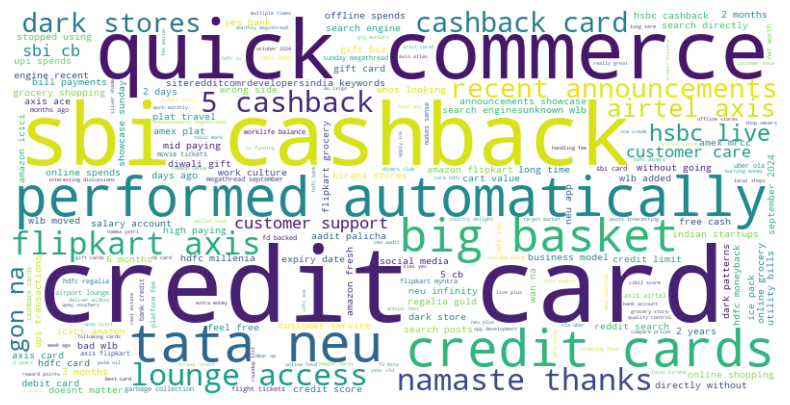

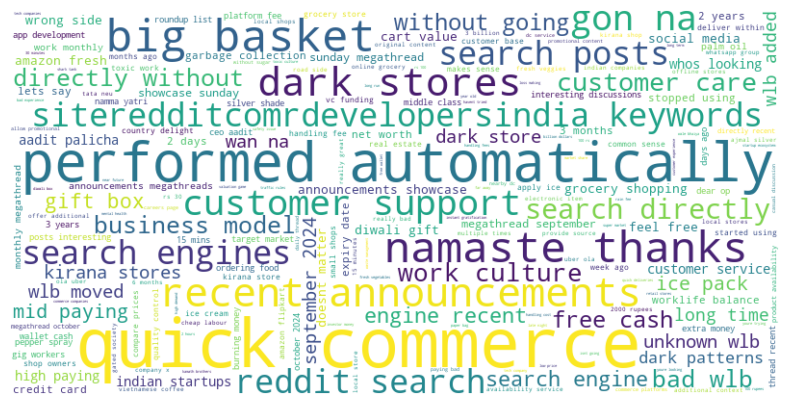

In [90]:
from wordcloud import WordCloud
from collections import Counter
from nltk.util import ngrams
import matplotlib.pyplot as plt

all_text = " ".join(zepto_df['all_text'])
tokens = nltk.word_tokenize(all_text.lower())

bigrams = list(ngrams(tokens, 2))
filtered_bigrams = [" ".join(bigram) for bigram in bigrams if not any(word in custom_stopwords for word in bigram)]

bigram_freq = Counter(filtered_bigrams)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white"
).generate_from_frequencies(bigram_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off") 
plt.show()

all_text = " ".join(zepto_df[zepto_df['subreddit']!='CreditCardsIndia']['all_text'])
tokens = nltk.word_tokenize(all_text.lower())

bigrams = list(ngrams(tokens, 2))
filtered_bigrams = [" ".join(bigram) for bigram in bigrams if not any(word in custom_stopwords for word in bigram)]

bigram_freq = Counter(filtered_bigrams)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white"
).generate_from_frequencies(bigram_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off") 
plt.show()



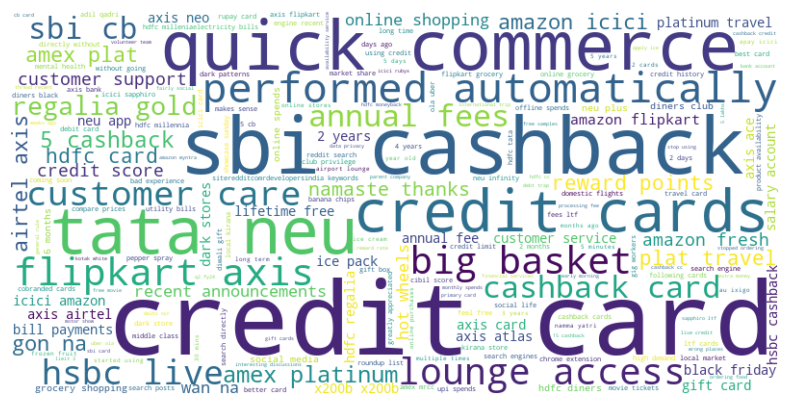

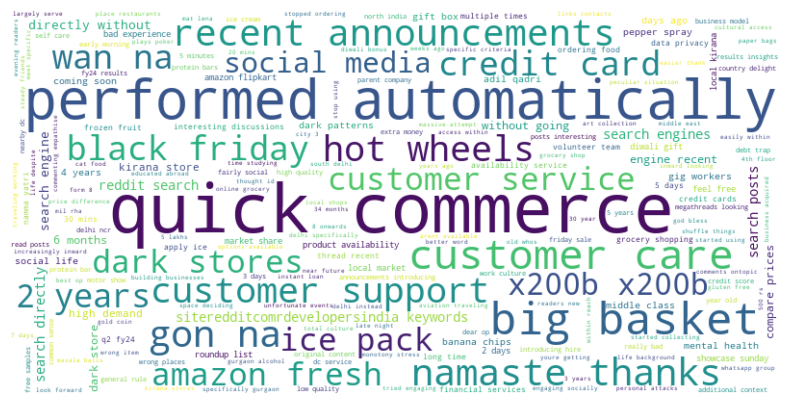

In [92]:
all_text = " ".join(blinkit_df['all_text'])
tokens = nltk.word_tokenize(all_text.lower())

bigrams = list(ngrams(tokens, 2))
filtered_bigrams = [" ".join(bigram) for bigram in bigrams if not any(word in custom_stopwords for word in bigram)]

bigram_freq = Counter(filtered_bigrams)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white"
).generate_from_frequencies(bigram_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off") 
plt.show()

all_text = " ".join(blinkit_df[blinkit_df['subreddit']!='CreditCardsIndia']['all_text'])
tokens = nltk.word_tokenize(all_text.lower())

bigrams = list(ngrams(tokens, 2))
filtered_bigrams = [" ".join(bigram) for bigram in bigrams if not any(word in custom_stopwords for word in bigram)]

bigram_freq = Counter(filtered_bigrams)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white"
).generate_from_frequencies(bigram_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off") 
plt.show()



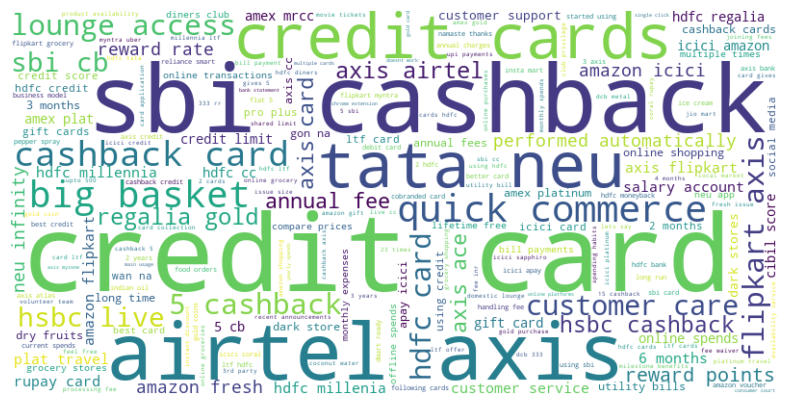

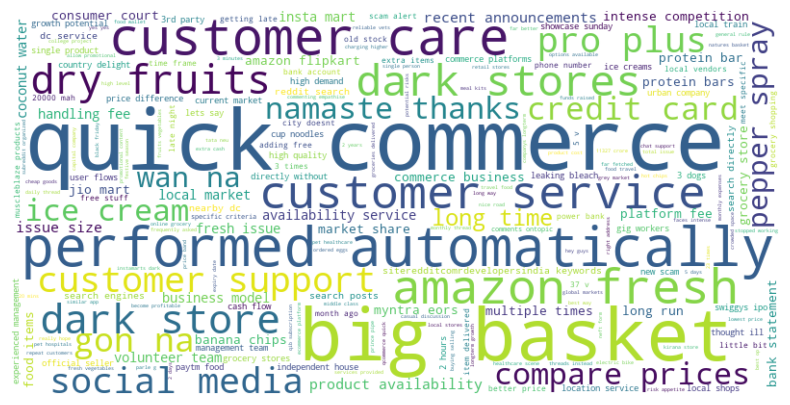

In [97]:
all_text = " ".join(instamart_df['all_text'])
tokens = nltk.word_tokenize(all_text.lower())

bigrams = list(ngrams(tokens, 2))
filtered_bigrams = [" ".join(bigram) for bigram in bigrams if not any(word in custom_stopwords for word in bigram)]

bigram_freq = Counter(filtered_bigrams)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white"
).generate_from_frequencies(bigram_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off") 
plt.show()

all_text = " ".join(instamart_df[instamart_df['subreddit']!='CreditCardsIndia']['all_text'])
tokens = nltk.word_tokenize(all_text.lower())

bigrams = list(ngrams(tokens, 2))
filtered_bigrams = [" ".join(bigram) for bigram in bigrams if not any(word in custom_stopwords for word in bigram)]

bigram_freq = Counter(filtered_bigrams)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white"
).generate_from_frequencies(bigram_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off") 
plt.show()



In [52]:
zepto_df=pd.read_json('zep_topics.json')
instamart_df=pd.read_json('inst_topics.json')
blinkit_df=pd.read_json('blink_topics.json')

In [362]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from transformers import pipeline
import nltk

nltk.download('vader_lexicon')

vader = SentimentIntensityAnalyzer()
bert = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")
roberta = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

def vader_analysis(text):
    sentiment = vader.polarity_scores(text)
    compound = sentiment["compound"]
    sentiment_label = (
        "positive" if compound > 0.05 else "negative" if compound < -0.05 else "neutral"
    )
    return compound, sentiment_label

def textblob_analysis(text):
    polarity = TextBlob(text).sentiment.polarity
    sentiment_label = (
        "positive" if polarity > 0 else "negative" if polarity < 0 else "neutral"
    )
    return polarity, sentiment_label

def bert_analysis(text):
    max_tokens = 512
    result = bert(text[:max_tokens])
    sentiment = result[0]["label"]
    score = result[0]["score"]
    return sentiment, score

def roberta_analysis(text):
    max_tokens = 512 
    result = roberta(text[:max_tokens])
    sentiment_label = result[0]["label"].lower()  
    score = result[0]["score"]
    return sentiment_label, score

def sentiments(df, text_column):
    results = []
    for text in df[text_column]:
        vader_compound, vader_sentiment = vader_analysis(text)
        textblob_polarity, textblob_sentiment = textblob_analysis(text)
        bert_sentiment, bert_score = bert_analysis(text)
        roberta_sentiment, roberta_score = roberta_analysis(text)

        results.append({
            "text": text,
            "vader_compound": vader_compound,
            "vader_sentiment": vader_sentiment,
            "textblob_polarity": textblob_polarity,
            "textblob_sentiment": textblob_sentiment,
            "bert_sentiment": bert_sentiment,
            "bert_score": bert_score,
            "roberta_sentiment": roberta_sentiment,
            "roberta_score": roberta_score,
        })

    results_df = pd.DataFrame(results)
    return results_df



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Mansha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [56]:
def bert_to_sentiment(star_label):
    if star_label in ["1 star", "2 stars"]:
        return "negative"
    elif star_label == "3 stars":
        return "neutral"
    elif star_label in ["4 stars", "5 stars"]:
        return "positive"
def roberta_to_sentiment(label):
    if label=='label_0':
        return 'negative'
    elif label=='label_1':
        return 'neutral'
    elif label=='label_2':
        return 'positive'

In [359]:
def get_overall_sentiment_with_weights(row):
    weights = {
        'vader_sentiment': 1,
        'textblob_sentiment': 1,
        'bert_sentiment': 2,  
        'roberta_sentiment': 3  
    }
    
    sentiments = []
    for model, weight in weights.items():
        sentiments.extend([row[model]] * weight)  
    
    sentiment_counts = {
        'positive': sentiments.count('positive'),
        'negative': sentiments.count('negative'),
        'neutral': sentiments.count('neutral')
    }

    max_count = max(sentiment_counts.values())
    tie_sentiments = [k for k, v in sentiment_counts.items() if v == max_count]
    
    if len(tie_sentiments) > 1:
        return 'neutral'
    return max(sentiment_counts, key=sentiment_counts.get)



In [363]:
zepto_sentiments=sentiments(zepto_df,'all_text')
zepto_sentiments['bert_sentiment']=zepto_sentiments['bert_sentiment'].apply(bert_to_sentiment)
zepto_sentiments['roberta_sentiment']=zepto_sentiments['roberta_sentiment'].apply(roberta_to_sentiment)

In [364]:
blinkit_sentiments = sentiments(blinkit_df, 'all_text')
blinkit_sentiments['bert_sentiment'] = blinkit_sentiments['bert_sentiment'].apply(bert_to_sentiment)
blinkit_sentiments['roberta_sentiment'] = blinkit_sentiments['roberta_sentiment'].apply(roberta_to_sentiment)

In [365]:
instamart_sentiments = sentiments(instamart_df, 'all_text')
instamart_sentiments['bert_sentiment'] = instamart_sentiments['bert_sentiment'].apply(bert_to_sentiment)
instamart_sentiments['roberta_sentiment'] = instamart_sentiments['roberta_sentiment'].apply(roberta_to_sentiment)

In [367]:
zepto_sentiments.to_json('zepto_sentiments.json')
blinkit_sentiments.to_json('blinkit_sentiments.json')
instamart_sentiments.to_json('instamart_sentiments.json')

In [368]:
zepto_sample = zepto_sentiments.sample(n=60, random_state=42) 
instamart_sample = instamart_sentiments.sample(n=60, random_state=42)
blinkit_sample = blinkit_sentiments.sample(n=60, random_state=42)
training_metamod = pd.concat([zepto_sample, instamart_sample, blinkit_sample], ignore_index=True)
training_metamod.to_json('training_data.json')

In [371]:
training_metamodf

,text,vader_compound,vader_sentiment,textblob_polarity,textblob_sentiment,bert_sentiment,bert_score,roberta_sentiment,roberta_score
0,should i get a credit card 18 hi guys i have r...,0.9975,positive,0.342105,positive,neutral,0.276868,positive,0.707316
1,need insights suggestion of my analysis se her...,0.9775,positive,0.037381,positive,neutral,0.324695,neutral,0.730272
2,yearly cyclone has really became norm in chenn...,-0.6789,negative,0.036220,positive,negative,0.379925,negative,0.795092
3,after bigbasket zepto and blinkit also starts ...,-0.8462,negative,0.033333,positive,negative,0.447379,negative,0.599143
4,zepto to move headquarters to bengaluru from m...,-0.0671,negative,0.247727,positive,neutral,0.260222,neutral,0.457689
...,...,...,...,...,...,...,...,...,...
175,blink it was preinstalled on my iphone after a...,0.2741,positive,0.066667,positive,negative,0.634677,neutral,0.561717
176,need suggestions from the gym peeps here so i ...,0.9962,positive,0.245111,positive,negative,0.374918,negative,0.703138
177,analysis paralysis first credit card hello eve...,0.9945,positive,0.279877,positive,negative,0.390809,neutral,0.688575
178,what to get after dcb fyf and sapphiro ltf i r...,0.9956,positive,0.088821,positive,neutral,0.259431,neutral,0.706036


In [62]:

zepto_sentiments['overall_sentiment'] = zepto_sentiments.apply(get_overall_sentiment_with_weights, axis=1)

blinkit_sentiments['overall_sentiment'] = blinkit_sentiments.apply(get_overall_sentiment_with_weights, axis=1)

instamart_sentiments['overall_sentiment'] = instamart_sentiments.apply(get_overall_sentiment_with_weights, axis=1)

In [64]:
zepto_sentiments

,text,vader_compound,vader_sentiment,textblob_polarity,textblob_sentiment,bert_sentiment,bert_score,roberta_sentiment,roberta_score,overall_sentiment
0,toxic work culture ft zepto i have been workin...,0.7581,positive,0.032222,positive,negative,0.691269,negative,0.947170,negative
1,zepto inside news leaked zepto didnt realize t...,0.1481,positive,0.102833,positive,negative,0.672598,negative,0.699523,negative
2,zepto is raising 300 million 2490 crore from t...,0.9042,positive,0.246078,positive,negative,0.647974,neutral,0.571773,neutral
3,zepto team works 80100 hours a week says ceo a...,-0.6484,negative,0.032024,positive,negative,0.732818,negative,0.923871,negative
4,zepto is the next amazon so how are they plann...,0.3384,positive,-0.003741,negative,negative,0.738944,negative,0.607885,negative
...,...,...,...,...,...,...,...,...,...,...
509,did you try zepto cafe the packaging is reall...,-0.5954,negative,0.152778,positive,negative,0.422667,positive,0.485297,positive
510,tried zepto cafe after a fellow redditor recom...,0.9766,positive,0.247917,positive,negative,0.274692,positive,0.980316,positive
511,zepto aaj kal zyada dayalu ban chuka hai 😋🤤😋\...,0.4588,positive,0.200000,positive,negative,0.727111,neutral,0.631381,neutral
512,zepto bag such a cute nd meaningful bag plea...,0.7650,positive,0.333333,positive,positive,0.474991,positive,0.897884,positive


In [65]:
import seaborn as sns
sns.set_theme(style="whitegrid")


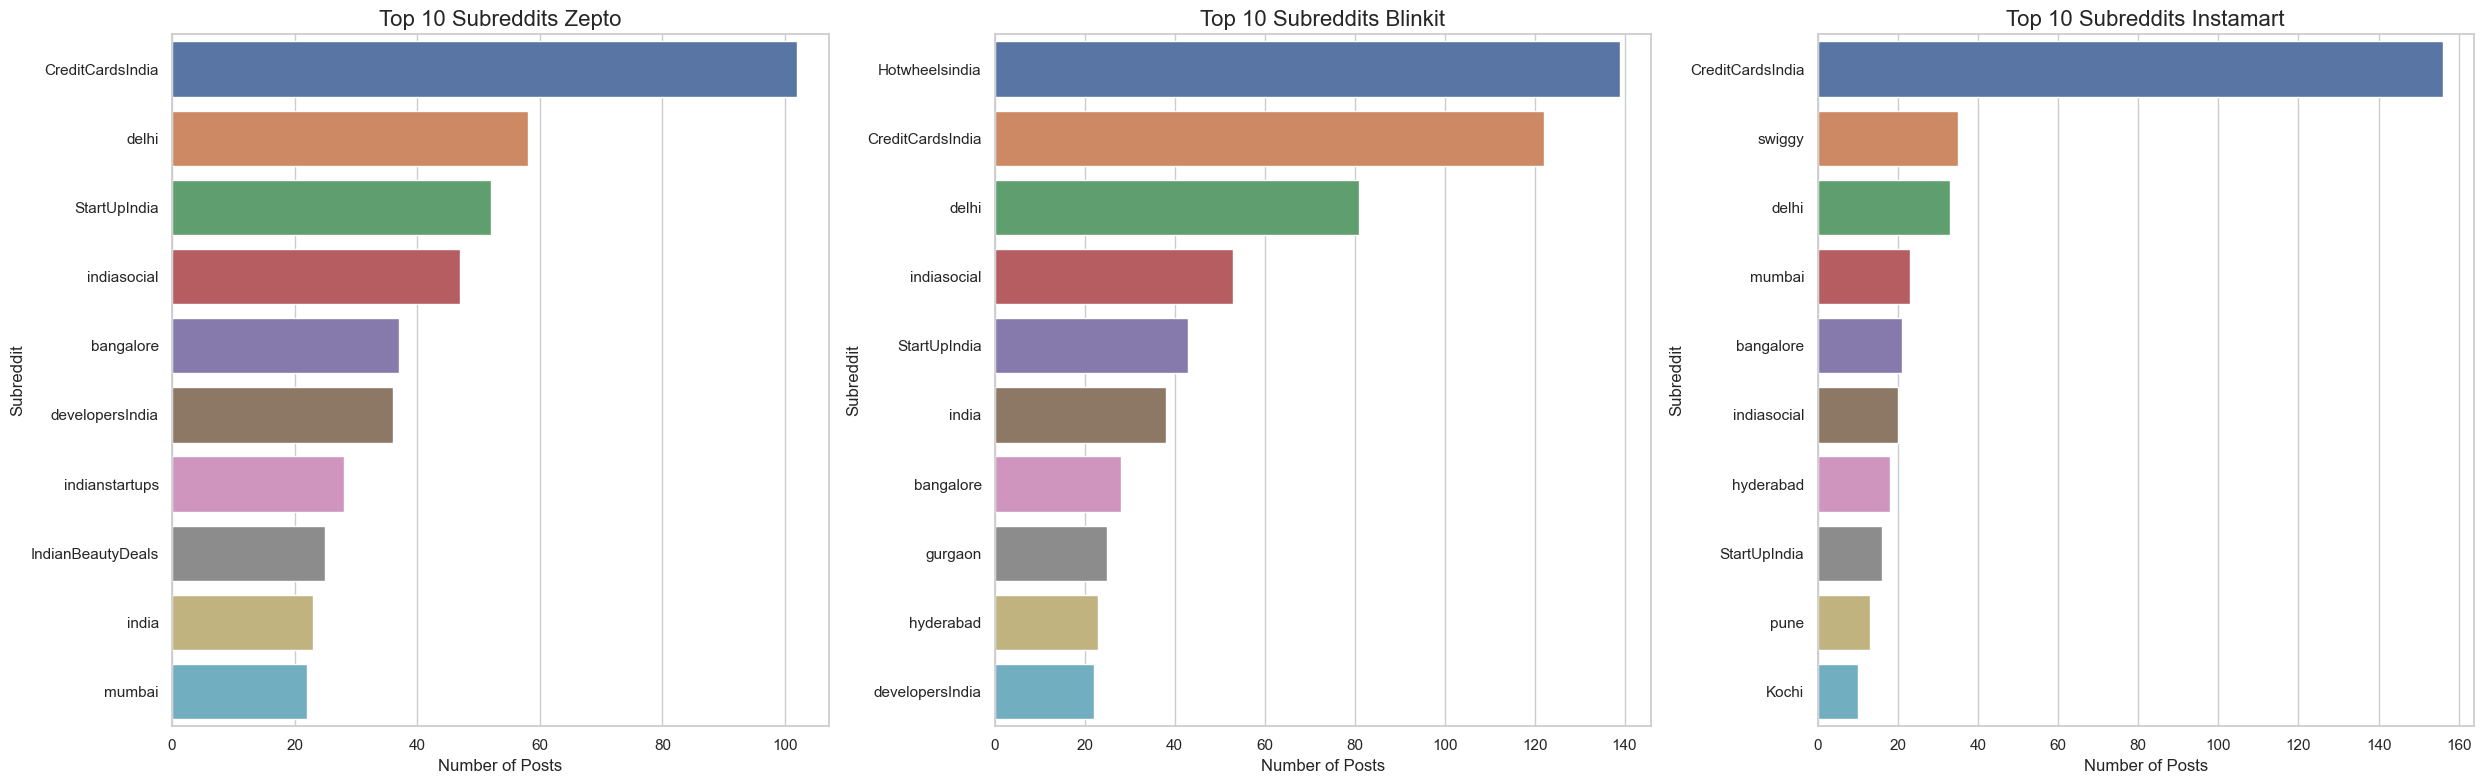

In [66]:
plt.figure(figsize=(25, 8))
plt.subplot(1,3,1)
top_subreddits = zepto_df['subreddit'].value_counts().head(10)
sns.barplot(x=top_subreddits.values, y=top_subreddits.index)
plt.title('Top 10 Subreddits Zepto', fontsize=16)
plt.xlabel('Number of Posts', fontsize=12)
plt.ylabel('Subreddit', fontsize=12)
plt.subplot(1,3,2)
top_subreddits = blinkit_df['subreddit'].value_counts().head(10)
sns.barplot(x=top_subreddits.values, y=top_subreddits.index)
plt.title('Top 10 Subreddits Blinkit', fontsize=16)
plt.xlabel('Number of Posts', fontsize=12)
plt.ylabel('Subreddit', fontsize=12)
plt.subplot(1,3,3)
top_subreddits = instamart_df['subreddit'].value_counts().head(10)
sns.barplot(x=top_subreddits.values, y=top_subreddits.index)
plt.title('Top 10 Subreddits Instamart', fontsize=16)
plt.xlabel('Number of Posts', fontsize=12)
plt.ylabel('Subreddit', fontsize=12)
plt.tight_layout()
plt.show()


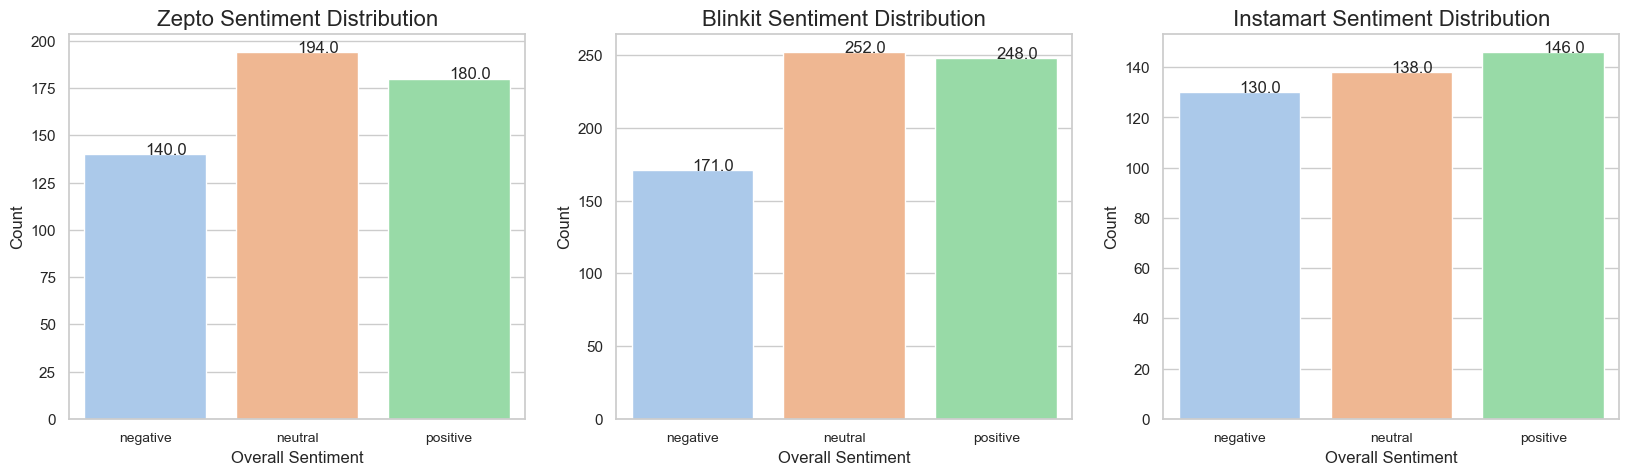

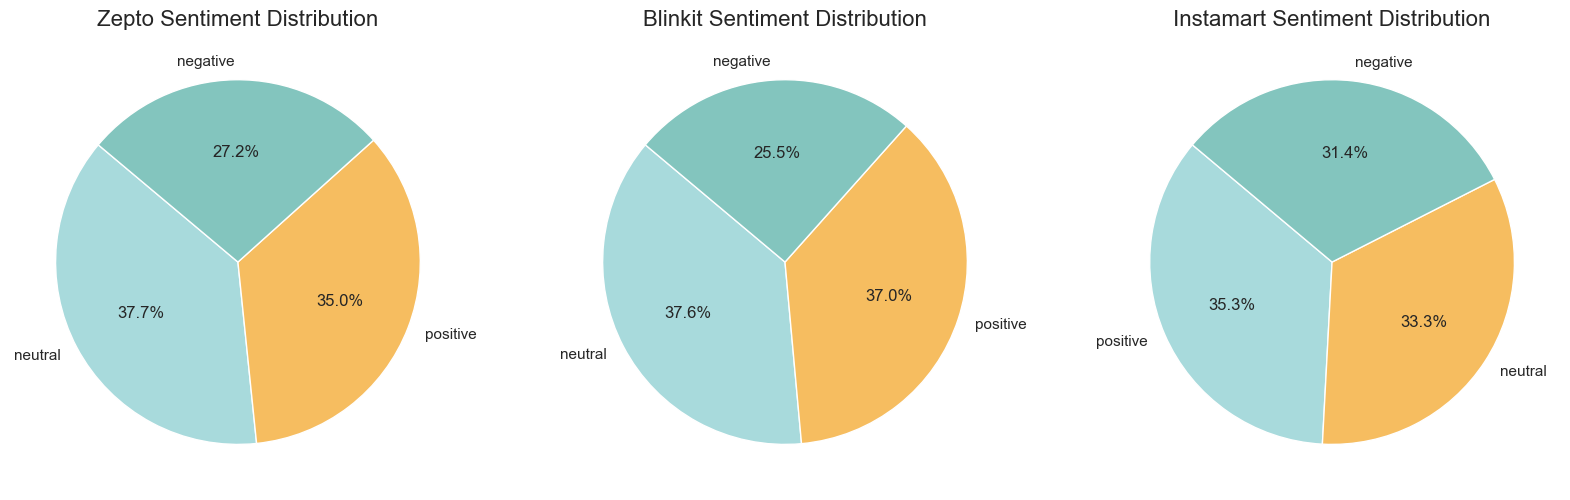

In [67]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
ax = sns.countplot(data=zepto_sentiments, x='overall_sentiment', palette='pastel',order=["negative", "neutral", "positive"])
plt.title('Zepto Sentiment Distribution', fontsize=16)
plt.xlabel('Overall Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()))
plt.subplot(1,3,2)
ax = sns.countplot(data=blinkit_sentiments, x='overall_sentiment', palette='pastel',order=["negative", "neutral", "positive"])
plt.title('Blinkit Sentiment Distribution', fontsize=16)
plt.xlabel('Overall Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()))
plt.subplot(1,3,3)
ax = sns.countplot(data=instamart_sentiments, x='overall_sentiment', palette='pastel',order=["negative", "neutral", "positive"])
plt.title('Instamart Sentiment Distribution', fontsize=16)
plt.xlabel('Overall Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()))
plt.show()

plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
zepto_counts = zepto_sentiments['overall_sentiment'].value_counts()
plt.pie(zepto_counts, labels=zepto_counts.index, autopct='%1.1f%%', startangle=140, colors=['#a8dadc', '#f6bd60', '#83c5be'])
plt.title('Zepto Sentiment Distribution',fontsize=16)

plt.subplot(1,3,2)
blinkit_counts = blinkit_sentiments['overall_sentiment'].value_counts()
plt.pie(blinkit_counts, labels=blinkit_counts.index, autopct='%1.1f%%', startangle=140, colors=['#a8dadc', '#f6bd60', '#83c5be'])
plt.title('Blinkit Sentiment Distribution',fontsize=16)

plt.subplot(1,3,3)
instamart_counts = instamart_sentiments['overall_sentiment'].value_counts()
plt.pie(instamart_counts, labels=instamart_counts.index, autopct='%1.1f%%', startangle=140, colors=['#a8dadc', '#f6bd60', '#83c5be'])
plt.title('Instamart Sentiment Distribution',fontsize=16)

plt.show()


In [68]:
zep_topics=pd.read_json('zep_topics.json')
blink_topics=pd.read_json('blink_topics.json')
inst_topics=pd.read_json('inst_topics.json')

In [69]:
topics_i={0: ['time', 'service', 'product', 'issue', 'customer', 'item', 'price'],
 1: ['card', 'cashback', 'hdfc', 'axis', 'credit', 'sbi', 'amazon'],
 2: ['natural', 'store', 'cream', 'nic', 'different', 'ice', 'egg'],
 3: ['grocery', 'dmart', 'store', 'gold', 'shopping', 'ready']}
topic_names_i={0:'service',1:'card offers',2:'ice-cream/eggs',3:'grocery/gold'}

topics_b={0: ['time', 'year', 'product', 'company', 'price','service'],
1:  [ 'growth', 'seller', 'company', 'search', 'q2', 'fy24'],
2: ['best', 'box', 'egg', 'rice', 'biryani', 'life', 'company'],
3:  ['card', 'credit', 'cashback', 'amazon', 'hdfc', 'axis', 'sbi']}
topic_names_b={0:'service',1:'company growth/stocks',2:'grocery',3:'card offers'}

topics_z={0: ['company', 'placement', 'work', 'startup', 'job', 'cheating'],
1: ['card', 'cashback', 'credit', 'amazon', 'sbi', 'hdfc'],
2: ['cafe', 'coffee', 'vietnamese', 'ordered', 'box', 'available'],
3: ['store', 'grocery', 'price', 'time', 'money', 'shop', 'local']}
topic_names_z={0:'work/jobs',1:'card offers',2:'zepto cafe',3:'grocery/price'}



In [70]:
zep_topics['topic_name'] = zep_topics['dominant_topic'].map(topic_names_z)
inst_topics['topic_name'] = inst_topics['dominant_topic'].map(topic_names_i)
blink_topics['topic_name'] = blink_topics['dominant_topic'].map(topic_names_b)



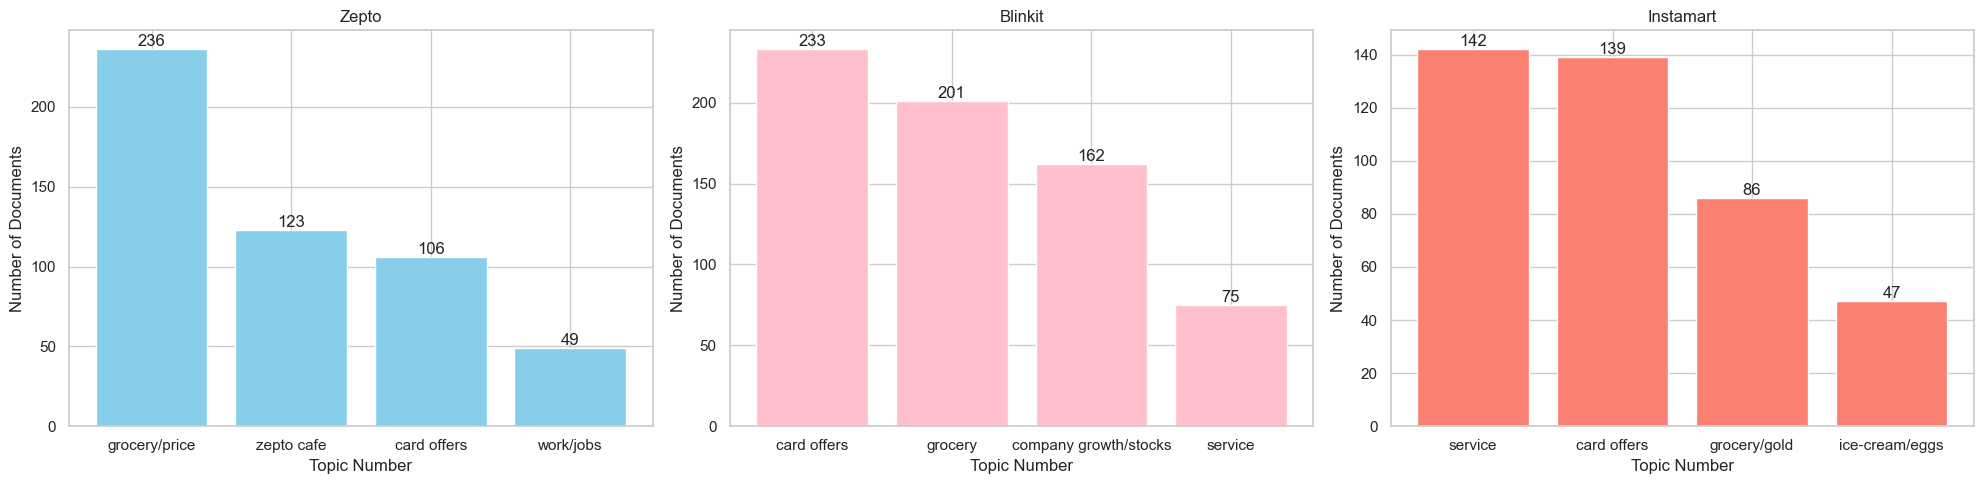

In [71]:
zep_topic_counts = zep_topics['topic_name'].value_counts()
inst_topic_counts = inst_topics['topic_name'].value_counts()
blink_topic_counts = blink_topics['topic_name'].value_counts()

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].bar(zep_topic_counts.index, zep_topic_counts,color='skyblue') 
axes[0].set_xlabel("Topic Number")
axes[0].set_ylabel("Number of Documents")
axes[0].set_title("Zepto")
for index, value in zip(zep_topic_counts.index, zep_topic_counts.values):
    axes[0].text(index, value, f'{value}', ha='center', va='bottom', fontsize=12)

axes[1].bar(blink_topic_counts.index, blink_topic_counts,color='pink')
axes[1].set_xlabel("Topic Number")
axes[1].set_ylabel("Number of Documents")
axes[1].set_title("Blinkit")
for index, value in zip(blink_topic_counts.index, blink_topic_counts.values):
    axes[1].text(index, value, f'{value}', ha='center', va='bottom', fontsize=12)

axes[2].bar(inst_topic_counts.index, inst_topic_counts,color='salmon')
axes[2].set_xlabel("Topic Number")
axes[2].set_ylabel("Number of Documents")
axes[2].set_title("Instamart")
for index, value in zip(inst_topic_counts.index, inst_topic_counts.values):
    axes[2].text(index, value, f'{value}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

In [89]:
zep_topics=zep_topics.reset_index()
zepto_sentiments=zepto_sentiments.rset_index()
inst_topics=inst_topics.reset_index()
instamart_sentiments=instamart_sentiments.reset_index()
blink_topics=blink_topics.reset_index()
blinkit_sentiments=blinkit_sentiments.reset_index()





In [90]:
zep_topics['overall_sentiment']=zepto_sentiments['overall_sentiment']
inst_topics['overall_sentiment']=instamart_sentiments['overall_sentiment']
blink_topics['overall_sentiment']=blinkit_sentiments['overall_sentiment']

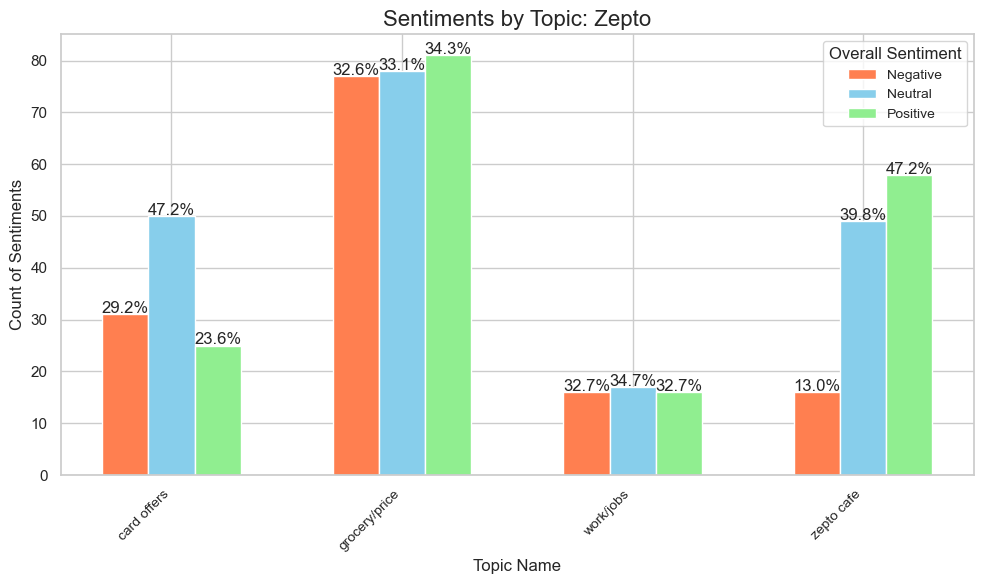

In [91]:

sentiment_counts = zep_topics.groupby(['topic_name', 'overall_sentiment']).size().unstack(fill_value=0)
percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100
x = np.arange(len(sentiment_counts.index))  
bar_width = 0.2  
sentiments = sentiment_counts.columns
colors = ['coral', 'skyblue', 'lightgreen'] 
fig, ax = plt.subplots(figsize=(10, 6))
for i, sentiment in enumerate(sentiments):
    bars = ax.bar(
        x + i * bar_width,
        sentiment_counts[sentiment],
        bar_width,
        label=sentiment.capitalize(),
        color=colors[i]
    )
    for bar, percentage in zip(bars, percentages[sentiment]):
        ax.text(
            bar.get_x() + bar.get_width() / 2,  
            bar.get_height() + 0.2,  
            f'{percentage:.1f}%',
            ha='center',
            fontsize=12
        )

ax.set_title('Sentiments by Topic: Zepto', fontsize=16)
ax.set_xlabel('Topic Name', fontsize=12)
ax.set_ylabel('Count of Sentiments', fontsize=12)
ax.set_xticks(x + bar_width)  
ax.set_xticklabels(sentiment_counts.index, rotation=45, ha='right', fontsize=10)
ax.legend(title='Overall Sentiment', fontsize=10)
plt.tight_layout()
plt.show()


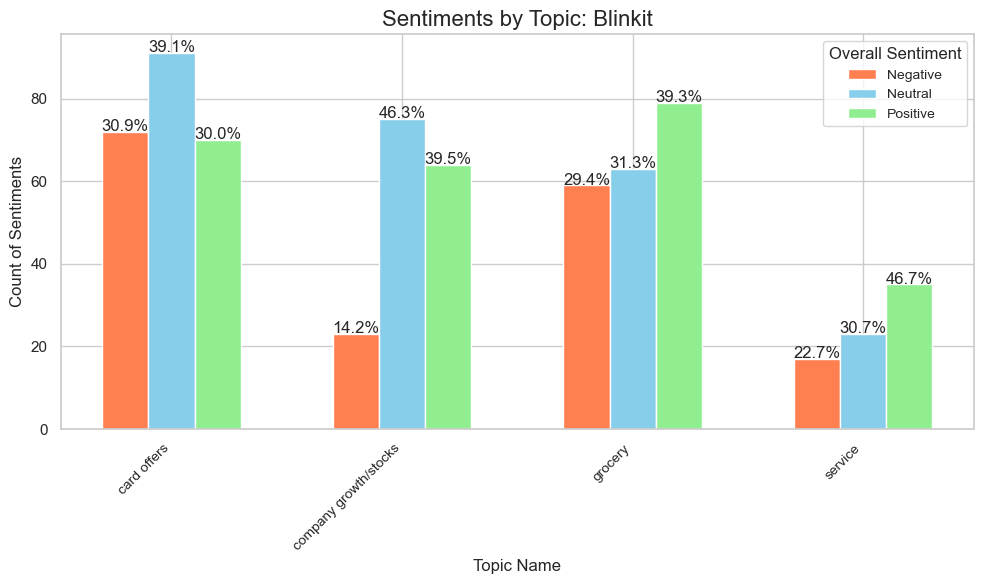

In [92]:
sentiment_counts = blink_topics.groupby(['topic_name', 'overall_sentiment']).size().unstack(fill_value=0)
percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100
x = np.arange(len(sentiment_counts.index))  
bar_width = 0.2  
sentiments = sentiment_counts.columns
colors = ['coral', 'skyblue', 'lightgreen'] 
fig, ax = plt.subplots(figsize=(10, 6))
for i, sentiment in enumerate(sentiments):
    bars = ax.bar(
        x + i * bar_width,
        sentiment_counts[sentiment],
        bar_width,
        label=sentiment.capitalize(),
        color=colors[i]
    )
    for bar, percentage in zip(bars, percentages[sentiment]):
        ax.text(
            bar.get_x() + bar.get_width() / 2,  
            bar.get_height() + 0.2,  
            f'{percentage:.1f}%',
            ha='center',
            fontsize=12
        )

ax.set_title('Sentiments by Topic: Blinkit', fontsize=16)
ax.set_xlabel('Topic Name', fontsize=12)
ax.set_ylabel('Count of Sentiments', fontsize=12)
ax.set_xticks(x + bar_width)  
ax.set_xticklabels(sentiment_counts.index, rotation=45, ha='right', fontsize=10)
ax.legend(title='Overall Sentiment', fontsize=10)
plt.tight_layout()
plt.show()


In [83]:
zep_topics['overall_sentiment'].value_c

neutral     31
positive    24
negative    22
Name: overall_sentiment, dtype: int64

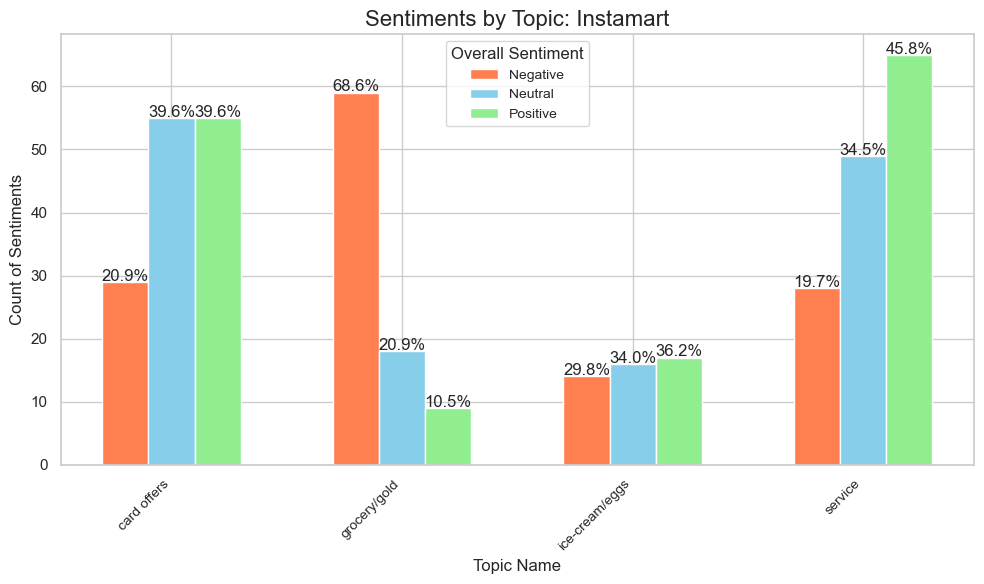

In [93]:
sentiment_counts = inst_topics.groupby(['topic_name', 'overall_sentiment']).size().unstack(fill_value=0)
percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100
x = np.arange(len(sentiment_counts.index))  
bar_width = 0.2  
sentiments = sentiment_counts.columns
colors = ['coral', 'skyblue', 'lightgreen'] 
fig, ax = plt.subplots(figsize=(10, 6))
for i, sentiment in enumerate(sentiments):
    bars = ax.bar(
        x + i * bar_width,
        sentiment_counts[sentiment],
        bar_width,
        label=sentiment.capitalize(),
        color=colors[i]
    )
    for bar, percentage in zip(bars, percentages[sentiment]):
        ax.text(
            bar.get_x() + bar.get_width() / 2,  
            bar.get_height() + 0.2,  
            f'{percentage:.1f}%',
            ha='center',
            fontsize=12
        )

ax.set_title('Sentiments by Topic: Instamart', fontsize=16)
ax.set_xlabel('Topic Name', fontsize=12)
ax.set_ylabel('Count of Sentiments', fontsize=12)
ax.set_xticks(x + bar_width)  
ax.set_xticklabels(sentiment_counts.index, rotation=45, ha='right', fontsize=10)
ax.legend(title='Overall Sentiment', fontsize=10)
plt.tight_layout()
plt.show()


# Scraping with keywords

In [342]:
def scrape_reddit(keyword, subreddit_name, num_comments=5, max_posts=100):

    subreddit = reddit.subreddit(subreddit_name)
    search_query = keyword
    sort_orders = ['relevance']
    all_data = []

    for sort_order in sort_orders:
        print(f"Starting search with sort order: {sort_order}")
        count = 0  
        for submission in subreddit.search(search_query, sort=sort_order, time_filter='year', limit=max_posts):
            top_comments = [
                comment.body for comment in submission.comments[:num_comments]
               if isinstance(comment, praw.models.Comment)
                ]
            
            all_data.append({
                'title': submission.title,
                'url': submission.url,
                'subreddit': subreddit_name,
                'text': submission.selftext,
                'comments': '\n'.join(top_comments),
                'sort_order': sort_order
            })
            count += 1
        

    print("All sort orders completed!")
    return pd.DataFrame(all_data)

zepto_keywords_app = ["zepto app", "zepto app glitch", "zepto app issue"]
zepto_keywords_support = ["zepto customer care", "zepto customer service", "zepto customer support"]
zepto_keywords_delivery=["zepto delivery time", "zepto delivery delay", "zepto quick delivery"]
zepto_keywords_grocery=["zepto freshness","zepto products","zepto quality"]

instamart_keywords_app = ["instamart app", "instamart app glitch", "instamart payment issue"]
instamart_keywords_support = ["instamart customer care", "instamart customer service", "instamart customer support"]
instamart_keywords_delivery=["instamart delivery time", "instamart delivery delay", "instamart quick delivery"]
instamart_keywords_grocery=["instamart freshness","instamart products","instamart quality"]

blinkit_keywords_app = ["blinkit app", "blinkit app glitch", "blinkit payment issue"]
blinkit_keywords_support = ["blinkit customer care", "blinkit customer service", "blinkit customer support"]
blinkit_keywords_delivery=["blinkit delivery time", "blinkit delivery delay", "blinkit quick delivery"]
blinkit_keywords_grocery=["blinkit freshness","blinkit products","blinkit quality"]


In [311]:
zepto_appp=scrape_reddit('zepto app', 'all', num_comments=5, max_posts=500)
zepto_app_glitch=scrape_reddit('zepto app glitch', 'all', num_comments=5, max_posts=500)
zepto_app_issue=scrape_reddit('zepto app issue', 'all', num_comments=5, max_posts=500)
zepto_app = pd.concat([zepto_appp, zepto_app_glitch, zepto_app_issue])
zepto_app.rename(columns={'text': 'selftext'}, inplace=True)
zepto_app = zepto_app.drop_duplicates('title')
zepto_app_df= filter_by_keyword(zepto_app, 'zepto')
zepto_app_df.to_json('zepto_app.json',orient='records')

Starting search with sort order: relevance
Completed sort order: relevance with 236 posts fetched.
All sort orders completed!
Starting search with sort order: relevance
Completed sort order: relevance with 248 posts fetched.
All sort orders completed!
Starting search with sort order: relevance
Completed sort order: relevance with 243 posts fetched.
All sort orders completed!


In [312]:
blinkit_appp = scrape_reddit('blinkit app', 'all', num_comments=5, max_posts=500)
blinkit_app_glitch = scrape_reddit('blinkit app glitch', 'all', num_comments=5, max_posts=500)
blinkit_app_issue = scrape_reddit('blinkit app issue', 'all', num_comments=5, max_posts=500)
blinkit_app = pd.concat([blinkit_appp, blinkit_app_glitch, blinkit_app_issue])
blinkit_app.rename(columns={'text': 'selftext'}, inplace=True)
blinkit_app = blinkit_app.drop_duplicates('title')
blinkit_app_df = filter_by_keyword(blinkit_app, 'blinkit')
blinkit_app_df.to_json('blinkit_app.json', orient='records')


Starting search with sort order: relevance
Completed sort order: relevance with 243 posts fetched.
All sort orders completed!
Starting search with sort order: relevance
Completed sort order: relevance with 248 posts fetched.
All sort orders completed!
Starting search with sort order: relevance
Completed sort order: relevance with 242 posts fetched.
All sort orders completed!


In [313]:
instamart_appp = scrape_reddit('instamart app', 'all', num_comments=5, max_posts=500)
instamart_app_glitch = scrape_reddit('instamart app glitch', 'all', num_comments=5, max_posts=500)
instamart_app_issue = scrape_reddit('instamart app issue', 'all', num_comments=5, max_posts=500)
instamart_app = pd.concat([instamart_appp, instamart_app_glitch, instamart_app_issue])
instamart_app.rename(columns={'text': 'selftext'}, inplace=True)
instamart_app = instamart_app.drop_duplicates('title')
instamart_app_df = filter_by_keyword(instamart_app, 'instamart')
instamart_app_df.to_json('instamart_app.json', orient='records')


Starting search with sort order: relevance
Completed sort order: relevance with 196 posts fetched.
All sort orders completed!
Starting search with sort order: relevance
Completed sort order: relevance with 248 posts fetched.
All sort orders completed!
Starting search with sort order: relevance
Completed sort order: relevance with 243 posts fetched.
All sort orders completed!


In [314]:
zepto_freshness = scrape_reddit('zepto freshness', 'all', num_comments=5, max_posts=500)
zepto_products = scrape_reddit('zepto products', 'all', num_comments=5, max_posts=500)
zepto_quality = scrape_reddit('zepto quality', 'all', num_comments=5, max_posts=500)
zepto_grocery = pd.concat([zepto_freshness, zepto_products, zepto_quality])
zepto_grocery.rename(columns={'text': 'selftext'}, inplace=True)
zepto_grocery = zepto_grocery.drop_duplicates('title')
zepto_grocery_df = filter_by_keyword(zepto_grocery, 'zepto')
zepto_grocery_df.to_json('zepto_grocery_products.json', orient='records')

Starting search with sort order: relevance
Completed sort order: relevance with 33 posts fetched.
All sort orders completed!
Starting search with sort order: relevance
Completed sort order: relevance with 151 posts fetched.
All sort orders completed!
Starting search with sort order: relevance
Completed sort order: relevance with 39 posts fetched.
All sort orders completed!


In [315]:
blinkit_freshness = scrape_reddit('blinkit freshness', 'all', num_comments=5, max_posts=500)
blinkit_products = scrape_reddit('blinkit products', 'all', num_comments=5, max_posts=500)
blinkit_quality = scrape_reddit('blinkit quality', 'all', num_comments=5, max_posts=500)
blinkit_grocery = pd.concat([blinkit_freshness, blinkit_products, blinkit_quality])
blinkit_grocery.rename(columns={'text': 'selftext'}, inplace=True)
blinkit_grocery = blinkit_grocery.drop_duplicates('title')
blinkit_grocery_df = filter_by_keyword(blinkit_grocery, 'blinkit')
blinkit_grocery_df.to_json('blinkit_grocery_products.json', orient='records')

Starting search with sort order: relevance
Completed sort order: relevance with 46 posts fetched.
All sort orders completed!
Starting search with sort order: relevance
Completed sort order: relevance with 152 posts fetched.
All sort orders completed!
Starting search with sort order: relevance
Completed sort order: relevance with 43 posts fetched.
All sort orders completed!


In [316]:
instamart_freshness = scrape_reddit('instamart freshness', 'all', num_comments=5, max_posts=500)
instamart_products = scrape_reddit('instamart products', 'all', num_comments=5, max_posts=500)
instamart_quality = scrape_reddit('instamart quality', 'all', num_comments=5, max_posts=500)
instamart_grocery = pd.concat([instamart_freshness, instamart_products, instamart_quality])
instamart_grocery.rename(columns={'text': 'selftext'}, inplace=True)
instamart_grocery = instamart_grocery.drop_duplicates('title')
instamart_grocery_df = filter_by_keyword(instamart_grocery, 'instamart')
instamart_grocery_df.to_json('instamart_grocery_products.json', orient='records')


Starting search with sort order: relevance
Completed sort order: relevance with 61 posts fetched.
All sort orders completed!
Starting search with sort order: relevance
Completed sort order: relevance with 83 posts fetched.
All sort orders completed!
Starting search with sort order: relevance
Completed sort order: relevance with 25 posts fetched.
All sort orders completed!


In [253]:
zepto_delivery_time=scrape_reddit('zepto delivery time', 'all', num_comments=5, max_posts=500)
zepto_delivery_delay=scrape_reddit('zepto delivery delay', 'all', num_comments=5, max_posts=500)
zepto_quick_delivery=scrape_reddit('zepto quick delivery', 'all', num_comments=5, max_posts=500)

Starting search with sort order: relevance
Completed sort order: relevance with 238 posts fetched.
All sort orders completed!


In [292]:
zepto_delivery=zepto_delivery_time

In [293]:
zepto_delivery=pd.concat([zepto_delivery,zepto_quick_delivery,zepto_delivery_delay])
zepto_delivery.rename(columns={'text':'selftext'},inplace=True)


In [298]:
zepto_delivery=zepto_delivery.drop_duplicates('title')
zepto_delivery_df=filter_by_keyword(zepto_delivery,'zepto')
zepto_delivery_df.to_json('zepto_delivery.json',orient='records')

In [299]:
instamart_delivery_time = scrape_reddit('instamart delivery time', 'all', num_comments=5, max_posts=500)
instamart_delivery_delay = scrape_reddit('instamart delivery delay', 'all', num_comments=5, max_posts=500)
instamart_quick_delivery = scrape_reddit('instamart quick delivery', 'all', num_comments=5, max_posts=500)
instamart_delivery = instamart_delivery_time
instamart_delivery = pd.concat([instamart_delivery, instamart_quick_delivery, instamart_delivery_delay])
instamart_delivery.rename(columns={'text': 'selftext'}, inplace=True)
instamart_delivery = instamart_delivery.drop_duplicates('title')
instamart_delivery_df = filter_by_keyword(instamart_delivery, 'instamart')
instamart_delivery_df.to_json('instamart_delivery.json',orient='records')


Starting search with sort order: relevance
Completed sort order: relevance with 239 posts fetched.
All sort orders completed!
Starting search with sort order: relevance
Completed sort order: relevance with 246 posts fetched.
All sort orders completed!
Starting search with sort order: relevance
Completed sort order: relevance with 242 posts fetched.
All sort orders completed!


In [300]:
blinkit_delivery_time = scrape_reddit('blinkit delivery time', 'all', num_comments=5, max_posts=500)
blinkit_delivery_delay = scrape_reddit('blinkit delivery delay', 'all', num_comments=5, max_posts=500)
blinkit_quick_delivery = scrape_reddit('blinkit quick delivery', 'all', num_comments=5, max_posts=500)
blinkit_delivery = blinkit_delivery_time

blinkit_delivery = pd.concat([blinkit_delivery, blinkit_quick_delivery, blinkit_delivery_delay])
blinkit_delivery.rename(columns={'text': 'selftext'}, inplace=True)

blinkit_delivery = blinkit_delivery.drop_duplicates('title')
blinkit_delivery_df = filter_by_keyword(blinkit_delivery, 'blinkit')
blinkit_delivery_df.to_json('blinkit_delivery.json',orient='records')


Starting search with sort order: relevance
Completed sort order: relevance with 236 posts fetched.
All sort orders completed!
Starting search with sort order: relevance
Completed sort order: relevance with 246 posts fetched.
All sort orders completed!
Starting search with sort order: relevance
Completed sort order: relevance with 195 posts fetched.
All sort orders completed!


In [307]:
zepto_cs1=scrape_reddit('zepto customer care', 'all', num_comments=5, max_posts=500)
zepto_cs2=scrape_reddit('zepto customer service', 'all', num_comments=5, max_posts=500)
zepto_cs3=scrape_reddit('zepto customer support', 'all', num_comments=5, max_posts=500)
zepto_customer=pd.concat([zepto_cs1,zepto_cs2,zepto_cs3])
zepto_customer.rename(columns={'text':'selftext'},inplace=True)

zepto_customer=zepto_customer.drop_duplicates('title')
zepto_customer_df=filter_by_keyword(zepto_customer,'zepto')
zepto_customer_df.to_json('zepto_customer.json',orient='records')
zepto_customer_df

Starting search with sort order: relevance
Completed sort order: relevance with 242 posts fetched.
All sort orders completed!
Starting search with sort order: relevance
Completed sort order: relevance with 247 posts fetched.
All sort orders completed!
Starting search with sort order: relevance
Completed sort order: relevance with 246 posts fetched.
All sort orders completed!


,title,url,subreddit,selftext,comments,sort_order
0,Toxic work culture ft. Zepto,https://www.reddit.com/r/StartUpIndia/comments...,all,I have been working with Zepto for a year now....,Bold of u to post bro ! This shit should go vi...,relevance
1,Zepto will not survive. Founders living in a d...,https://www.reddit.com/r/IndianStockMarket/com...,all,bold,"\nIf you haven't already, please add your own ...",relevance
2,Zepto is Overcharging Customers – My Shocking ...,https://www.reddit.com/gallery/1h243o9,all,"\n\nHey everyone,\n\nI wanted to share a distu...",First thing cigarettes are not included in zep...,relevance
4,Title: Zepto is Overcharging Customers – My Sh...,https://www.reddit.com/r/LegalAdviceIndia/comm...,all,"\nHey everyone,\n\nI wanted to share a disturb...","As far as I am aware, free delivery/discounts/...",relevance
5,Despite fund raising Zepto want to lose custom...,https://www.reddit.com/gallery/1atm1s2,all,This is just a rant on Zepto and how they are ...,Not looking to grind your gears but the roses ...,relevance
6,Zepto Users Beware,https://www.reddit.com/r/bangalore/comments/1g...,all,"Today, I ordered groceries from Zepto and the ...",The warehouse is infested; record a video and ...,relevance
7,Zepto scam Beware,https://www.reddit.com/r/bangalore/comments/1f...,all,\nRecently I experienced a fraud from zepto wh...,This happened to me twice on Blinkit! Shocked ...,relevance
8,Buddha hoga tera baap!,https://www.reddit.com/gallery/1gylajm,all,Key words : Mom Perfumes \n\nRaphael Fragrance...,"Dear OP,\n\nThis will be my first and final re...",relevance
9,Saw a Grown-Up Porter Delivery Guy Cry,https://www.reddit.com/r/delhi/comments/1fn04h...,all,Recently saw a guy's encounter with a Zepto gu...,"On a serious note, you're a good dude, champ. ...",relevance
11,ZEPTO SUCKS NOT GIVING US REFUND WHAT TO DO BO...,https://www.reddit.com/r/IndianTeenagers/comme...,all,# had ordered a bunch of items but didnt reciv...,"# We are looking for new mods, feel free to ap...",relevance


In [308]:
instamart_cs1 = scrape_reddit('instamart customer care', 'all', num_comments=5, max_posts=500)
instamart_cs2 = scrape_reddit('instamart customer service', 'all', num_comments=5, max_posts=500)
instamart_cs3 = scrape_reddit('instamart customer support', 'all', num_comments=5, max_posts=500)
instamart_customer = pd.concat([instamart_cs1, instamart_cs2, instamart_cs3])
instamart_customer.rename(columns={'text': 'selftext'}, inplace=True)

instamart_customer = instamart_customer.drop_duplicates('title')
instamart_customer_df = filter_by_keyword(instamart_customer, 'instamart')
instamart_customer_df.to_json('instamart_customer.json', orient='records')
instamart_customer_df


Starting search with sort order: relevance
Completed sort order: relevance with 243 posts fetched.
All sort orders completed!
Starting search with sort order: relevance
Completed sort order: relevance with 247 posts fetched.
All sort orders completed!
Starting search with sort order: relevance
Completed sort order: relevance with 246 posts fetched.
All sort orders completed!


,title,url,subreddit,selftext,comments,sort_order
0,Instamart Customer care asking for Bank Statement,https://www.reddit.com/r/swiggy/comments/1gut1...,all,I ordered a product of Rs. 235 on 25th Oct and...,It's SOP if refund not initiated or stuck. You...,relevance
1,Bought Gold on Instamart,https://www.reddit.com/gallery/1geoih5,all,I saw a post in this sub where HDFC Swiggy Cre...,Keep us updated what happens\nI think you ll g...,relevance
3,How to contact Swiggy Customer care,https://www.reddit.com/r/swiggy/comments/1g53o...,all,I want to contact the swiggy instamart custome...,Select any thing randomly. It will ultimately ...,relevance
4,"This time, got the real beasts!",https://i.redd.it/ck1g47qsvu3e1.jpeg,all,"A while back, I made the rookie mistake of cal...",Wow bro! SBI Cashback and Axis Ace are the mos...,relevance
5,Scam or what I don't know,https://www.reddit.com/gallery/1h8350x,all,I ordered a 20000 mah power bank on instamart ...,Ordering a power bank through swiggy? Not sure...,relevance
6,New Swiggy Scam Alert,https://i.redd.it/v5lofbga3old1.jpeg,all,Swiggy Instamart . I placed a order on 21/7/24...,Too brave to make that large order online!\nSe...,relevance
7,Is it worth it ?,https://www.reddit.com/gallery/1d5f5hv,all,Got this card LTF and I wanted to know does th...,"Yes, after the new changes, all your Swiggy(Sw...",relevance
9,Does taking multiple cards reduce the chances ...,https://i.redd.it/gurrvjxfe28e1.jpeg,all,I have been using the following cards-\n1) Ame...,not at all. that's how it grows in fact.\nwhat...,relevance
10,Is HSBC Live+ not offering 10% Cashback on Fli...,https://www.reddit.com/gallery/1g2hylc,all,"Hey Fellow Credit Card Enthusiasts,\n\nI recen...",no Flipkart Grocery doesn't fall under Grocery...,relevance
11,E-commerce Industry News Recap 🔥 Week of Dec 1...,https://www.reddit.com/r/ecommerce/comments/1h...,all,Hi r/ecommerce \- I'm Paul and I follow the e-...,**Here are some highlights from the Winter '25...,relevance


In [309]:
blinkit_cs1 = scrape_reddit('blinkit customer care', 'all', num_comments=5, max_posts=500)
blinkit_cs2 = scrape_reddit('blinkit customer service', 'all', num_comments=5, max_posts=500)
blinkit_cs3 = scrape_reddit('blinkit customer support', 'all', num_comments=5, max_posts=500)
blinkit_customer = pd.concat([blinkit_cs1, blinkit_cs2, blinkit_cs3])
blinkit_customer.rename(columns={'text': 'selftext'}, inplace=True)

blinkit_customer = blinkit_customer.drop_duplicates('title')
blinkit_customer_df = filter_by_keyword(blinkit_customer, 'blinkit')
blinkit_customer_df.to_json('blinkit_customer.json', orient='records')
blinkit_customer_df


Starting search with sort order: relevance
Completed sort order: relevance with 241 posts fetched.
All sort orders completed!
Starting search with sort order: relevance
Completed sort order: relevance with 246 posts fetched.
All sort orders completed!
Starting search with sort order: relevance
Completed sort order: relevance with 245 posts fetched.
All sort orders completed!


,title,url,subreddit,selftext,comments,sort_order
0,Toxic work culture ft. Zepto,https://www.reddit.com/r/StartUpIndia/comments...,all,I have been working with Zepto for a year now....,Bold of u to post bro ! This shit should go vi...,relevance
1,Blinkit's Diwali Gift,https://www.reddit.com/r/indiasocial/comments/...,all,Ordered for more than Rs.1000/- on Blinkit and...,"You spent over Rs. 1000, and they couldn't eve...",relevance
2,Buddha hoga tera baap!,https://www.reddit.com/gallery/1gylajm,all,Key words : Mom Perfumes \n\nRaphael Fragrance...,"Dear OP,\n\nThis will be my first and final re...",relevance
4,Does taking multiple cards reduce the chances ...,https://i.redd.it/gurrvjxfe28e1.jpeg,all,I have been using the following cards-\n1) Ame...,not at all. that's how it grows in fact.\nwhat...,relevance
6,Is HSBC Live+ not offering 10% Cashback on Fli...,https://www.reddit.com/gallery/1g2hylc,all,"Hey Fellow Credit Card Enthusiasts,\n\nI recen...",no Flipkart Grocery doesn't fall under Grocery...,relevance
7,How to prepare for the worst economic outcome?,https://www.reddit.com/r/unitedstatesofindia/c...,all,How do I make money asap assuming the worst-ca...,"Gold, silver, bitcoin in cold storage, real es...",relevance
8,E-commerce Industry News Recap 🔥 Week of Dec 1...,https://www.reddit.com/r/ecommerce/comments/1h...,all,Hi r/ecommerce \- I'm Paul and I follow the e-...,**Here are some highlights from the Winter '25...,relevance
9,Confused About ON Whey Protein Authenticity,https://www.reddit.com/r/Fitness_India/comment...,all,I recently ordered **Optimum Nutrition Whey Pr...,Call here 01149594959\nEmail indiacustomercare...,relevance
10,"What's new in e-commerce? 🔥 Week of Dec 16th, ...",https://www.reddit.com/r/ShopifyeCommerce/comm...,all,Hi [r/ShopifyeCommerce/](https://www.reddit.co...,**Here are some highlights from the Winter '25...,relevance
11,Which cc to get,https://www.reddit.com/r/CreditCardsIndia/comm...,all,Hi all. So far i have been using shitty icici ...,Atlas\nAmex plat travel for a general CC up to...,relevance


# Delivery

In [128]:

def sentiment(df, text_column):
    sent=[]
    score=[]
    for text in df[text_column]:
        roberta_sentiment, roberta_score = roberta_analysis(text)
        sent.append(roberta_sentiment)
        score.append(roberta_score)
    df['roberta_sentiment']=sent
    df['roberta_score']=score
    return df


In [ ]:
zepto_delivery_df=pd.read_json('zepto_delivery.json')
instamart_delivery_df=pd.read_json('instamart_delivery.json')
blinkit_delivery_df=pd.read_json('blinkit_delivery.json')
zepto_delivery_df=filter_by_keyword(zepto_delivery_df,'delivery')
blinkit_delivery_df=filter_by_keyword(blinkit_delivery_df,'delivery')
instamart_delivery_df=filter_by_keyword(instamart_delivery_df,'delivery')
instamart_delivery_df=preprocess(instamart_delivery_df)
instamart_delivery_df['cleantext']=instamart_delivery_df['all_text'].apply(preprocess_text)
zepto_delivery_df=preprocess(zepto_delivery_df)
zepto_delivery_df['cleantext']=zepto_delivery_df['all_text'].apply(preprocess_text)
blinkit_delivery_df=preprocess(blinkit_delivery_df)
blinkit_delivery_df['cleantext']=blinkit_delivery_df['all_text'].apply(preprocess_text)


In [130]:
zepto_delivery_df=sentiment(zepto_delivery_df,'all_text')
zepto_delivery_df['roberta_sentiment']=zepto_delivery_df['roberta_sentiment'].apply(roberta_to_sentiment)
zepto_delivery_df['roberta_sentiment'].value_counts()

neutral     27
positive    19
negative    12
Name: roberta_sentiment, dtype: int64

In [132]:
blinkit_delivery_df=sentiment(blinkit_delivery_df,'all_text')
blinkit_delivery_df['roberta_sentiment']=blinkit_delivery_df['roberta_sentiment'].apply(roberta_to_sentiment)
blinkit_delivery_df['roberta_sentiment'].value_counts()

neutral     34
positive    28
negative    26
Name: roberta_sentiment, dtype: int64

In [133]:
instamart_delivery_df=sentiment(instamart_delivery_df,'all_text')
instamart_delivery_df['roberta_sentiment'].value_counts()

neutral     33
negative    18
positive    12
Name: roberta_sentiment, dtype: int64

In [188]:

def aspect_sentiment(row, keyword):
    
    sentiment_results = []
    aspect_text = keyword 
    sentence = row['all_text']
    inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect_text} [SEP]", return_tensors="pt")
    outputs = absa_model(**inputs)
    probs = F.softmax(outputs.logits, dim=1).detach().numpy()[0]
    sentiment_labels = ["negative", "neutral", "positive"]
    sentiment = {label: prob for label, prob in zip(sentiment_labels, probs)}
    sentiment_results.append({**sentiment, 'aspect': aspect_text, 'text': sentence})

    return sentiment_results

def assign_label_absa(row):
    max_score = -1
    max_label = None

    if isinstance(row['aspect_sentiment'], list):
        for item in row['aspect_sentiment']:
            # Check if item is itself a list (list of lists of dictionaries)
            if isinstance(item, list):
                for sentiment_dict in item:
                    max_score=sentiment_dict['neutral']
                    max_label='neutral'
                    if sentiment_dict['positive']>max_score:
                        max_score=sentiment_dict['positive']
                        max_label='positive'
                    if sentiment_dict['negative']>max_score:
                        max_score=sentiment_dict['negative']
                        max_label='negative'

    return max_label







In [137]:
zepto_delivery_df['aspect_sentiment']=zepto_delivery_df.apply(lambda row: [aspect_sentiment(row, 'zepto')], axis=1)


In [ ]:
zepto_delivery_df['absa_sentiment']=zepto_delivery_df.apply(assign_label_absa, axis=1)
zepto_delivery_df.to_json('zepto_delivery.json')

In [185]:
zepto_delivery_df['roberta_sentiment'].value_counts()

neutral     27
positive    19
negative    12
Name: roberta_sentiment, dtype: int64

In [186]:
zepto_delivery_df['absa_sentiment'].value_counts()

negative    26
positive    17
neutral     15
Name: absa_sentiment, dtype: int64

In [189]:
blinkit_delivery_df['aspect_sentiment'] = blinkit_delivery_df.apply(lambda row: [aspect_sentiment(row, 'blinkit')], axis=1)

blinkit_delivery_df['absa_sentiment'] = blinkit_delivery_df.apply(assign_label_absa, axis=1)
blinkit_delivery_df.to_json('blinkit_delivery.json')
blinkit_delivery_df['absa_sentiment'].value_counts()


negative    36
positive    31
neutral     21
Name: absa_sentiment, dtype: int64

In [197]:
blinkit_delivery_df['roberta_sentiment'].value_counts()


neutral     34
positive    28
negative    26
Name: roberta_sentiment, dtype: int64

In [190]:
instamart_delivery_df['aspect_sentiment'] = instamart_delivery_df.apply(lambda row: [aspect_sentiment(row, 'instamart')], axis=1)

instamart_delivery_df['absa_sentiment'] = instamart_delivery_df.apply(assign_label_absa, axis=1)
instamart_delivery_df.to_json('instamart_delivery.json')
instamart_delivery_df['absa_sentiment'].value_counts()


negative    30
neutral     18
positive    15
Name: absa_sentiment, dtype: int64

In [193]:
instamart_delivery_df['roberta_sentiment'].value_counts()


neutral     33
negative    18
positive    12
Name: roberta_sentiment, dtype: int64

# Customer Support

In [198]:
zepto_customer_df = pd.read_json('zepto_customer.json')
instamart_customer_df = pd.read_json('instamart_customer.json')
blinkit_customer_df = pd.read_json('blinkit_customer.json')

In [209]:

zepto_customer_df = filter_by_keyword(zepto_customer_df, 'customer')
blinkit_customer_df = filter_by_keyword(blinkit_customer_df, 'customer')
instamart_customer_df = filter_by_keyword(instamart_customer_df, 'customer')
instamart_customer_df = preprocess(instamart_customer_df)
instamart_customer_df['cleantext'] = instamart_customer_df['all_text'].apply(preprocess_text)
zepto_customer_df = preprocess(zepto_customer_df)
zepto_customer_df['cleantext'] = zepto_customer_df['all_text'].apply(preprocess_text)
blinkit_customer_df = preprocess(blinkit_customer_df)
blinkit_customer_df['cleantext'] = blinkit_customer_df['all_text'].apply(preprocess_text)


C:\Users\Mansha\AppData\Local\Temp\ipykernel_17180\2877329958.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['selftext'] = df['selftext']
C:\Users\Mansha\AppData\Local\Temp\ipykernel_17180\2877329958.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['posttext'] = df['title'].astype(str) + ' '+ df['selftext'].astype(str)
C:\Users\Mansha\AppData\Local\Temp\ipykernel_17180\2877329958.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [211]:

zepto_customer_df = sentiment(zepto_customer_df, 'all_text')
zepto_customer_df['roberta_sentiment'] = zepto_customer_df['roberta_sentiment'].apply(roberta_to_sentiment)
zepto_customer_df['roberta_sentiment'].value_counts()


C:\Users\Mansha\AppData\Local\Temp\ipykernel_17180\1784292823.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['roberta_sentiment']=sent
C:\Users\Mansha\AppData\Local\Temp\ipykernel_17180\1784292823.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['roberta_score']=score
C:\Users\Mansha\AppData\Local\Temp\ipykernel_17180\2564085969.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

negative    23
neutral      8
positive     8
Name: roberta_sentiment, dtype: int64

In [212]:
blinkit_customer_df = sentiment(blinkit_customer_df, 'all_text')
blinkit_customer_df['roberta_sentiment'] = blinkit_customer_df['roberta_sentiment'].apply(roberta_to_sentiment)
blinkit_customer_df['roberta_sentiment'].value_counts()

C:\Users\Mansha\AppData\Local\Temp\ipykernel_17180\1784292823.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['roberta_sentiment']=sent
C:\Users\Mansha\AppData\Local\Temp\ipykernel_17180\1784292823.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['roberta_score']=score
C:\Users\Mansha\AppData\Local\Temp\ipykernel_17180\100752457.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

negative    20
neutral      6
positive     5
Name: roberta_sentiment, dtype: int64

In [213]:

instamart_customer_df = sentiment(instamart_customer_df, 'all_text')
instamart_customer_df['roberta_sentiment'] = instamart_customer_df['roberta_sentiment'].apply(roberta_to_sentiment)
instamart_customer_df['roberta_sentiment'].value_counts()


negative    22
neutral     14
positive     5
Name: roberta_sentiment, dtype: int64

In [214]:

zepto_customer_df['aspect_sentiment'] = zepto_customer_df.apply(lambda row: [aspect_sentiment(row, 'zepto')], axis=1)

zepto_customer_df['absa_sentiment'] = zepto_customer_df.apply(assign_label_absa, axis=1)
zepto_customer_df.to_json('zepto_customer_filtered.json')
zepto_customer_df['roberta_sentiment'].value_counts()
zepto_customer_df['absa_sentiment'].value_counts()



C:\Users\Mansha\AppData\Local\Temp\ipykernel_17180\1763757234.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zepto_customer_df['aspect_sentiment'] = zepto_customer_df.apply(lambda row: [aspect_sentiment(row, 'zepto')], axis=1)
C:\Users\Mansha\AppData\Local\Temp\ipykernel_17180\1763757234.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zepto_customer_df['absa_sentiment'] = zepto_customer_df.apply(assign_label_absa, axis=1)


negative    32
positive     4
neutral      3
Name: absa_sentiment, dtype: int64

In [215]:

blinkit_customer_df['aspect_sentiment'] = blinkit_customer_df.apply(lambda row: [aspect_sentiment(row, 'blinkit')], axis=1)

blinkit_customer_df['absa_sentiment'] = blinkit_customer_df.apply(assign_label_absa, axis=1)
blinkit_customer_df.to_json('blinkit_customer_filtered.json')
blinkit_customer_df['absa_sentiment'].value_counts()

blinkit_customer_df['roberta_sentiment'].value_counts()

C:\Users\Mansha\AppData\Local\Temp\ipykernel_17180\1837884047.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blinkit_customer_df['aspect_sentiment'] = blinkit_customer_df.apply(lambda row: [aspect_sentiment(row, 'blinkit')], axis=1)
C:\Users\Mansha\AppData\Local\Temp\ipykernel_17180\1837884047.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blinkit_customer_df['absa_sentiment'] = blinkit_customer_df.apply(assign_label_absa, axis=1)


negative    20
neutral      6
positive     5
Name: roberta_sentiment, dtype: int64

In [216]:

instamart_customer_df['aspect_sentiment'] = instamart_customer_df.apply(lambda row: [aspect_sentiment(row, 'instamart')], axis=1)

instamart_customer_df['absa_sentiment'] = instamart_customer_df.apply(assign_label_absa, axis=1)
instamart_customer_df.to_json('instamart_customer_filtered.json')
instamart_customer_df['absa_sentiment'].value_counts()

instamart_customer_df['roberta_sentiment'].value_counts()

negative    22
neutral     14
positive     5
Name: roberta_sentiment, dtype: int64

# App

In [217]:
zepto_app_df = pd.read_json('zepto_app.json')
instamart_app_df = pd.read_json('instamart_app.json')
blinkit_app_df = pd.read_json('blinkit_app.json')

In [218]:

zepto_app_df = filter_by_keyword(zepto_app_df, 'app')
blinkit_app_df = filter_by_keyword(blinkit_app_df, 'app')
instamart_app_df = filter_by_keyword(instamart_app_df, 'app')
instamart_app_df = preprocess(instamart_app_df)

In [219]:
instamart_app_df['cleantext'] = instamart_app_df['all_text'].apply(preprocess_text)
zepto_app_df = preprocess(zepto_app_df)
zepto_app_df['cleantext'] = zepto_app_df['all_text'].apply(preprocess_text)
blinkit_app_df = preprocess(blinkit_app_df)
blinkit_app_df['cleantext'] = blinkit_app_df['all_text'].apply(preprocess_text)

In [220]:

zepto_app_df = sentiment(zepto_app_df, 'all_text')
zepto_app_df['roberta_sentiment'] = zepto_app_df['roberta_sentiment'].apply(roberta_to_sentiment)
zepto_app_df['roberta_sentiment'].value_counts()


neutral     57
positive    35
negative    27
Name: roberta_sentiment, dtype: int64

In [221]:

blinkit_app_df = sentiment(blinkit_app_df, 'all_text')
blinkit_app_df['roberta_sentiment'] = blinkit_app_df['roberta_sentiment'].apply(roberta_to_sentiment)
blinkit_app_df['roberta_sentiment'].value_counts()


neutral     40
positive    28
negative    24
Name: roberta_sentiment, dtype: int64

In [222]:

instamart_app_df = sentiment(instamart_app_df, 'all_text')
instamart_app_df['roberta_sentiment'] = instamart_app_df['roberta_sentiment'].apply(roberta_to_sentiment)
instamart_app_df['roberta_sentiment'].value_counts()

neutral     33
positive    20
negative    20
Name: roberta_sentiment, dtype: int64

In [223]:

zepto_app_df['aspect_sentiment'] = zepto_app_df.apply(lambda row: [aspect_sentiment(row, 'zepto')], axis=1)
zepto_app_df['absa_sentiment'] = zepto_app_df.apply(assign_label_absa, axis=1)
zepto_app_df.to_json('zepto_app_filtered.json')
zepto_app_df['roberta_sentiment'].value_counts()


neutral     57
positive    35
negative    27
Name: roberta_sentiment, dtype: int64

In [224]:
zepto_app_df['absa_sentiment'].value_counts()

negative    53
neutral     37
positive    29
Name: absa_sentiment, dtype: int64

In [225]:

blinkit_app_df['aspect_sentiment'] = blinkit_app_df.apply(lambda row: [aspect_sentiment(row, 'blinkit')], axis=1)
blinkit_app_df['absa_sentiment'] = blinkit_app_df.apply(assign_label_absa, axis=1)
blinkit_app_df.to_json('blinkit_app_filtered.json')
blinkit_app_df['absa_sentiment'].value_counts()


negative    36
neutral     33
positive    23
Name: absa_sentiment, dtype: int64

In [226]:
blinkit_app_df['roberta_sentiment'].value_counts()


neutral     40
positive    28
negative    24
Name: roberta_sentiment, dtype: int64

In [227]:

instamart_app_df['aspect_sentiment'] = instamart_app_df.apply(lambda row: [aspect_sentiment(row, 'instamart')], axis=1)
instamart_app_df['absa_sentiment'] = instamart_app_df.apply(assign_label_absa, axis=1)
instamart_app_df.to_json('instamart_app_filtered.json')
instamart_app_df['absa_sentiment'].value_counts()


negative    36
neutral     27
positive    10
Name: absa_sentiment, dtype: int64

In [228]:
instamart_app_df['roberta_sentiment'].value_counts()

neutral     33
positive    20
negative    20
Name: roberta_sentiment, dtype: int64

# Grocey

In [229]:
zepto_grocery_products_df = pd.read_json('zepto_grocery_products.json')
instamart_grocery_products_df = pd.read_json('instamart_grocery_products.json')
blinkit_grocery_products_df = pd.read_json('blinkit_grocery_products.json')

In [247]:
instamart_grocery_products_df = preprocess(instamart_grocery_products_df)
instamart_grocery_products_df['cleantext'] = instamart_grocery_products_df['all_text'].apply(preprocess_text)

In [248]:
zepto_grocery_products_df = preprocess(zepto_grocery_products_df)
zepto_grocery_products_df['cleantext'] = zepto_grocery_products_df['all_text'].apply(preprocess_text)

In [249]:

blinkit_grocery_products_df = preprocess(blinkit_grocery_products_df)
blinkit_grocery_products_df['cleantext'] = blinkit_grocery_products_df['all_text'].apply(preprocess_text)

In [250]:

zepto_grocery_products_df = sentiment(zepto_grocery_products_df, 'all_text')
zepto_grocery_products_df['roberta_sentiment'] = zepto_grocery_products_df['roberta_sentiment'].apply(roberta_to_sentiment)
zepto_grocery_products_df['roberta_sentiment'].value_counts()

neutral     68
positive    50
negative    37
Name: roberta_sentiment, dtype: int64

In [251]:

blinkit_grocery_products_df = sentiment(blinkit_grocery_products_df, 'all_text')
blinkit_grocery_products_df['roberta_sentiment'] = blinkit_grocery_products_df['roberta_sentiment'].apply(roberta_to_sentiment)
blinkit_grocery_products_df['roberta_sentiment'].value_counts()


neutral     68
positive    57
negative    40
Name: roberta_sentiment, dtype: int64

In [252]:

instamart_grocery_products_df = sentiment(instamart_grocery_products_df, 'all_text')
instamart_grocery_products_df['roberta_sentiment'] = instamart_grocery_products_df['roberta_sentiment'].apply(roberta_to_sentiment)
instamart_grocery_products_df['roberta_sentiment'].value_counts()

neutral     48
negative    36
positive    32
Name: roberta_sentiment, dtype: int64

In [253]:

zepto_grocery_products_df['aspect_sentiment'] = zepto_grocery_products_df.apply(lambda row: [aspect_sentiment(row, 'zepto')], axis=1)
zepto_grocery_products_df['absa_sentiment'] = zepto_grocery_products_df.apply(assign_label_absa, axis=1)
zepto_grocery_products_df.to_json('zepto_grocery_products_filtered.json')
zepto_grocery_products_df['absa_sentiment'].value_counts()


neutral     59
negative    55
positive    41
Name: absa_sentiment, dtype: int64

In [254]:
zepto_grocery_products_df['roberta_sentiment'].value_counts()


neutral     68
positive    50
negative    37
Name: roberta_sentiment, dtype: int64

In [255]:

blinkit_grocery_products_df['aspect_sentiment'] = blinkit_grocery_products_df.apply(lambda row: [aspect_sentiment(row, 'blinkit')], axis=1)
blinkit_grocery_products_df['absa_sentiment'] = blinkit_grocery_products_df.apply(assign_label_absa, axis=1)
blinkit_grocery_products_df.to_json('blinkit_grocery_products_filtered.json')
blinkit_grocery_products_df['absa_sentiment'].value_counts()

neutral     66
positive    54
negative    45
Name: absa_sentiment, dtype: int64

In [256]:
blinkit_grocery_products_df['roberta_sentiment'].value_counts()

neutral     68
positive    57
negative    40
Name: roberta_sentiment, dtype: int64

In [257]:

instamart_grocery_products_df['aspect_sentiment'] = instamart_grocery_products_df.apply(lambda row: [aspect_sentiment(row, 'instamart')], axis=1)
instamart_grocery_products_df['absa_sentiment'] = instamart_grocery_products_df.apply(assign_label_absa, axis=1)
instamart_grocery_products_df.to_json('instamart_grocery_products_filtered.json')
instamart_grocery_products_df['absa_sentiment'].value_counts()

negative    51
neutral     49
positive    16
Name: absa_sentiment, dtype: int64

In [259]:
instamart_grocery_products_df

,title,url,subreddit,selftext,comments,sort_order,posttext,all_text,cleantext,roberta_sentiment,roberta_score,aspect_sentiment,absa_sentiment
0,Is Chicken / pork salami and other cold cuts t...,https://www.reddit.com/r/Fitness_India/comment...,all,i am a non vegetarian but only eat non veg twi...,Why don't you find a local butcher and buy bon...,relevance,Is Chicken / pork salami and other cold cuts t...,is chicken pork salami and other cold cuts th...,"[chicken, pork, salami, cold, cut, amazon, fre...",negative,0.508665,"[[{'negative': 0.18427823, 'neutral': 0.076697...",positive
1,The price of 'convenience' you are paying,https://i.redd.it/7kndk1trqc6e1.png,all,exhibit 1 amazon fresh charging rs 329 for 30 ...,And the local shop on my street sells a 30-egg...,relevance,The price of 'convenience' you are paying Exhi...,the price of convenience you are paying exhibi...,"[price, convenience, paying, exhibit, amazon, ...",neutral,0.532406,"[[{'negative': 0.78444886, 'neutral': 0.150973...",negative
2,Is Amazon Fresh any good? Or should I stick to...,https://www.reddit.com/r/IndianFood/comments/1...,all,hi all just moved to bangalore ive been wantin...,,relevance,Is Amazon Fresh any good? Or should I stick to...,is amazon fresh any good or should i stick to ...,"[amazon, fresh, stick, moved, bangalore, wanti...",neutral,0.502396,"[[{'negative': 0.011457305, 'neutral': 0.90581...",neutral
3,I save Rs. 5000 every month by simply not orde...,https://www.reddit.com/r/Frugal_Ind/comments/1...,all,i order chicken from my local shop at rs 250kg...,"This is the way to go OP.\nYep, I did exactly ...",relevance,I save Rs. 5000 every month by simply not orde...,i save rs 5000 every month by simply not order...,"[save, r, 5000, month, simply, ordering, onlin...",neutral,0.581477,"[[{'negative': 0.46120876, 'neutral': 0.215313...",negative
4,India’s Grocery wars,https://i.redd.it/q212bk2mp17d1.jpeg,all,a deloitte report estimates indian quick comme...,Outdated chart.\n\nBig basket delivers within ...,relevance,India’s Grocery wars A Deloitte report estimat...,indias grocery wars a deloitte report estimate...,"[india, grocery, war, deloitte, report, estima...",positive,0.746114,"[[{'negative': 0.16961353, 'neutral': 0.596985...",neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,Good quality sourdough bread in Indore?,https://www.reddit.com/r/Indore/comments/1hg6n...,all,where can i find good quality sourdough bread ...,Bhiya Raam! \n\nPlease remember to put a corre...,relevance,Good quality sourdough bread in Indore? Where...,good quality sourdough bread in indore where ...,"[quality, sourdough, bread, indore, quality, s...",neutral,0.547732,"[[{'negative': 0.07468138, 'neutral': 0.877517...",neutral
112,Have you ever regret buying fruits from Swiggy...,https://www.reddit.com/r/ahmedabad/comments/1g...,all,rotten hole in apples\n\n\n\n,Thats the reason i never buy any vegetables or...,relevance,Have you ever regret buying fruits from Swiggy...,have you ever regret buying fruits from swiggy...,"[regret, buying, fruit, rotten, hole, apple, t...",positive,0.697919,"[[{'negative': 0.87789315, 'neutral': 0.038637...",negative
113,How many of you are using Big Basket?,https://www.reddit.com/r/Trivandrum/comments/1...,all,so recently i bought vegetables from big baske...,Wow man I didn't know they were here. Installi...,relevance,How many of you are using Big Basket? So recen...,how many of you are using big basket so recent...,"[using, big, basket, recently, bought, vegetab...",positive,0.880928,"[[{'negative': 0.026801055, 'neutral': 0.83787...",neutral
114,Consumer Apps used by Delhities,https://www.reddit.com/r/delhi/comments/1gifqs...,all,i am just curious to know any new consumer app...,As an appreciation for your content contributi...,relevance,Consumer Apps used by Delhities I am just curi...,consumer apps used by delhities i am just curi...,"[consumer, used, delhities, curious, new, cons...",neutral,0.718440,"[[{'negative':

In [267]:
instamart_grocery_products_df['all_text'][97]


'iimc interview transcript location mumbai\n\n968677882\n\n18 months workex\n\ncs background\n\nx200b\n\n3 panelists 2m 1f\n\nf1 so what have you heard about our panel\n\nme i think everyone has had a good experience its been a bit math intensive but overall everyone has had a good experience\n\nf1 really laughs a good experience\n\nme well they have all come out smiling so i am assuming their experience has been good \n\nf1 smiling so what are your expectations\n\nme since i am the last candidate i am hoping you take it easy on me everyone laughs\n\nm1 so how good is your math\n\nme to be honest sir i have lost touch with math\n\nm2 pretends to be shocked how will you survive in iimc then we are very focused on math\n\nme its not like i cannot do math sir i have studied it at an engineering level its just that i have lost touch with it because it wasnt in the curriculum post second year and i did not need it in my work\n\nm1 what about cat\n\nme sir i had a specific strategy for cat i

In [264]:
'''
dictionary_z = corpora.Dictionary(zepto_df["cleantext"])
corpus_z = [dictionary_z.doc2bow(text) for text in zepto_df["cleantext"]]
num_topics = 4  
lda_model = LdaModel(
    corpus=corpus_z,
    id2word=dictionary_z,
    num_topics=num_topics,
    random_state=42,
    chunksize=100,
    passes=15,
    alpha=0.4,
    eta=0.2,
    iterations=100
)

zepto_df['assigned_topic'] = assign_topics(lda_model, corpus_z)


for topic_id in range(num_topics):
    print(f"Topic {topic_id}:")
    print(lda_model.print_topic(topic_id, topn=7))
    print()
random.seed(19)

dictionary_b = corpora.Dictionary(blinkit_df["cleantext"])
corpus_b = [dictionary_b.doc2bow(text) for text in blinkit_df["cleantext"]]
num_topics = 4  
lda_model = LdaModel(
    corpus=corpus_b,
    id2word=dictionary_b,
    num_topics=num_topics,
    chunksize=100,
    passes=15,
    alpha=0.4,
    eta=0.2,
    random_state=55,
    iterations=100
)


blinkit_df['assigned_topic'] = assign_topics(lda_model, corpus_b)


for topic_id in range(num_topics):
    print(f"Topic {topic_id}:")
    print(lda_model.print_topic(topic_id, topn=7))
    print()


dictionary_i = corpora.Dictionary(instamart_df["cleantext"])
corpus_i = [dictionary_i.doc2bow(text) for text in instamart_df["cleantext"]]
num_topics = 4  
lda_model = LdaModel(
    corpus=corpus_i,
    id2word=dictionary_b,
    num_topics=num_topics,
    chunksize=100,
    passes=15,
    alpha=0.4,
    eta=0.2,
    random_state=66,
    iterations=100
)


instamart_df['assigned_topic'] = assign_topics(lda_model, corpus_i)


for topic_id in range(num_topics):
    print(f"Topic {topic_id}:")
    print(lda_model.print_topic(topic_id, topn=7))
    print()
'''

'\ndictionary_z = corpora.Dictionary(zepto_df["cleantext"])\ncorpus_z = [dictionary_z.doc2bow(text) for text in zepto_df["cleantext"]]\nnum_topics = 4  \nlda_model = LdaModel(\n    corpus=corpus_z,\n    id2word=dictionary_z,\n    num_topics=num_topics,\n    random_state=42,\n    chunksize=100,\n    passes=15,\n    alpha=0.4,\n    eta=0.2,\n    iterations=100\n)\n\nzepto_df[\'assigned_topic\'] = assign_topics(lda_model, corpus_z)\n\n\nfor topic_id in range(num_topics):\n    print(f"Topic {topic_id}:")\n    print(lda_model.print_topic(topic_id, topn=7))\n    print()\nrandom.seed(19)\n\ndictionary_b = corpora.Dictionary(blinkit_df["cleantext"])\ncorpus_b = [dictionary_b.doc2bow(text) for text in blinkit_df["cleantext"]]\nnum_topics = 4  \nlda_model = LdaModel(\n    corpus=corpus_b,\n    id2word=dictionary_b,\n    num_topics=num_topics,\n    chunksize=100,\n    passes=15,\n    alpha=0.4,\n    eta=0.2,\n    random_state=55,\n    iterations=100\n)\n\n\nblinkit_df[\'assigned_topic\'] = assign

In [258]:

instamart_grocery_products_df['roberta_sentiment'].value_counts()

neutral     48
negative    36
positive    32
Name: roberta_sentiment, dtype: int64